## > Importing Liberaries && Some Function

In [1]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

2024-05-12 20:41:33.298232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:41:33.298280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:41:33.299760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [3]:
History_dict = {}
Model_dict = {}

def add_to_model_dict(model ,model_name):
    if(model_name in Model_dict.keys()):
        print("model_already_there")
    else:
        Model_dict[model_name] = model

def add_to_history_dict(history ,model_name):
    if(model_name in History_dict.keys()):
        print("model_already_there")
    else:
        History_dict[model_name] = history

## > Loading Data

###  || Load Data from google drive 

In [4]:
# Model_dict

In [5]:
dataset_name = 'Hrf'
base_path = os.getcwd()+'/../input/'

dataset_base_path = base_path+'dataset-hrf/'+dataset_name

In [6]:
preprocesses =[
    "> Clahe , smoothing , Edge Detection" ,
    "> Resizeing  & Resclaing",
    "> Random Contrast , sharpness, Brightness",
    "> Random  Zoom , Shift , Flip , Rotate90",
]

In [7]:
config ={
    'dataset' : {
        '_image_shape' : (576,544),
    },
    'model' : {
        
    },
    
    'training' : {
        
    },
    'preprocesing' : '\n'.join(preprocesses),
}

Model_names = [ 'simple_unet' ,'residual_unet' ,'recuurent_unet','r2_unet' , 'residual_attention_unet']

In [8]:
# Flow data from directories
train_images_path = dataset_base_path +  '/Data/train/images/'
train_masks_path = dataset_base_path + '/Data/train/masks/'
val_images_path = dataset_base_path + '/Data/val/images/'
val_masks_path = dataset_base_path + '/Data/val/masks/'
test_images_path = dataset_base_path + '/Data/test/images/'
test_masks_path = dataset_base_path + '/Data/test/masks/'

In [9]:
def get_data(images_path , masks_path ):
    Images = []
    Masks = []
    try:
        ## Note : image Path ad Maks dir are same
        image_dirs = sorted(os.listdir(images_path)) 
        mask_dirs = sorted(os.listdir(masks_path))
        dirs = np.intersect1d(image_dirs , mask_dirs)
        
        try :
            for dir_ in tqdm(dirs):
                image_dir = images_path + dir_
                mask_dir = masks_path + dir_
                
                image = Image.open(image_dir)
                mask = Image.open(mask_dir)
                
                image = image.resize((1024,1024))
                mask = mask.resize((1024,1024))

                
                Images.append(np.array(image,dtype = np.uint8))
                Masks.append(np.array(mask , dtype = np.uint8))
            print( 'number of images :' ,len(Images))
        except Exception as e:
            print("Error Occured ",e)
            print(image)
    
    except Exception as e:
        print("Error Occured for path",e)

    return Images ,Masks

In [10]:
train_images , train_masks = get_data( train_images_path , train_masks_path)
test_images , test_masks = get_data( test_images_path , test_masks_path)
val_images , val_masks = get_data( val_images_path , val_masks_path)

100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


number of images : 31


100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


number of images : 9


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

number of images : 5


In [11]:
# List1 =['abc','bcd','aef']
# List2 =['abc',"sdb",'esf']

# List1 = sorted(List1)
# List2 = sorted(List2)

# np.intersect1d(List1,List2)

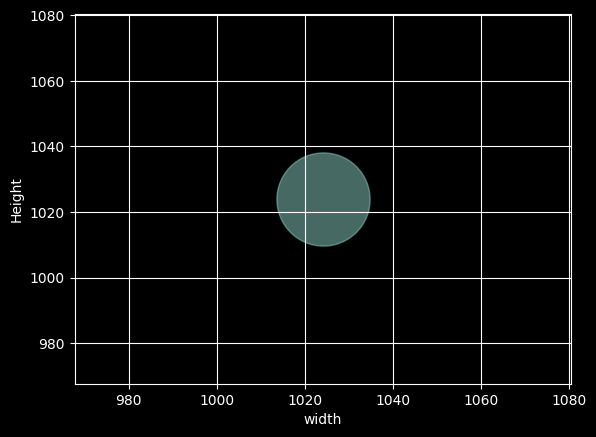

In [12]:
Dict = {}
for images in [train_images , test_images , val_images]:
    for image in images:
        im_shape = image.shape[:2]
        if(im_shape not in Dict.keys()):
            Dict[im_shape]=0
        Dict[im_shape] +=1

arr = np.array(list (Dict.keys())) 
num = np.array(list(Dict.values()))

plt.scatter(arr[:,1],arr[:,0] , s=num *100 ,alpha=0.5)
plt.ylabel('Height')
plt.xlabel('width')
plt.grid()
plt.show()

In [13]:
Dict 

{(1024, 1024): 45}

In [14]:
factor = 32
im_h =  1024
im_w = 1024

desired_shape = ( int(( im_h//factor )* factor) , int((im_w//factor) *factor) )
# desired_shape = (512,512)
config['dataset']['_image_shape'] = desired_shape

def  resize_images_to_numpy(Data ):
    List = []
    for image in tqdm(Data):
        # print(image.dtype)
        new_image = np.array(Image.fromarray(image).resize((desired_shape[1],desired_shape[0])))
        List.append(new_image)
        
    return np.array(List , dtype = np.float32)
    
def  resize_masks_to_numpy(Data):
    List = []
    for mask in tqdm(Data): ## implies RGB
        new_mask = Image.fromarray(mask).resize((desired_shape[1],desired_shape[0]))
        if( np.array(new_mask).ndim == 3):
            new_mask = np.arranp.sum(new_mask , axis=-1,keepdims=True)
        else: ## Implies  Graysclae
            new_mask = np.expand_dims(new_mask, axis = -1)
        
        new_mask = np.where(new_mask > 0 ,1 ,0)
    
        List.append(new_mask)
    return np.array(List , dtype = np.float32)

train_images = resize_images_to_numpy(train_images )
train_masks  = resize_masks_to_numpy(train_masks )

test_images = resize_images_to_numpy(test_images )
test_masks  = resize_masks_to_numpy(test_masks )

val_images = resize_images_to_numpy(val_images )
val_masks  = resize_masks_to_numpy(val_masks )

100%|██████████| 5/5 [00:00<00:00, 382.72it/s]


## > Preprocessing (only form images) & Datasplit

In [15]:
def image_01float_to_unit8(image_float):
    return (image_float*255).astype(np.uint8)
    
def image_clahe_gray(image , clipLimit  = 10 , tileGridLen = 10):
    clahe = cv2.createCLAHE(clipLimit=clipLimit , tileGridSize= (tileGridLen,tileGridLen) )
    # print(np.shape(image))
    # print(np.max(image) , np.array(image).dtype)
    clahe_image = clahe.apply(image)
    
    return clahe_image
# //---------------------------------------------------------------------------------------------------------------
def morphological_operations(image, kernel_size = 15,channel = 1):
    # Convert RGB image to grayscale
    # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    if( np.ndim(image)==3):
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
        # grayscale_image_cl = image_clahe_gray(grayscale_image,4,16)
    # Apply morphological operations (Top-hat filtering)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat_result = cv2.morphologyEx(grayscale_image, cv2.MORPH_TOPHAT, kernel)
    return tophat_result
    
# Apply gamma correction-----------------------------------------------------------------------------------
def image_gamma_corr( image , gamma = 1.5): ## Uint8 .
    std_image = image_standarize(image)
    
    corrected_image = np.power(std_image , 1/gamma)
    # Convert back to uint8 format
    corrected_image_uint8 = (corrected_image * 255).astype(np.uint8)
    return corrected_image_uint8
# ///-----------------------------------------------------------------------------------------------------------------
from skimage.filters import frangi

def frangi_vessel_enhancement(image , alpha = 0.5 ,beta=0.5, gamma=1 ,kernel_size = 5,channel = 1):
    # Convert RGB image to grayscale
    if(np.ndim(image) == 3):
        # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
    # Apply Frangi filter
    frangi_result = frangi(grayscale_image ,alpha = alpha ,beta=beta ,gamma = gamma ,) 
    frangi_result =  image_01float_to_unit8(frangi_result)
    # frangi_result = frangi(grayscale_image.
    blurred = cv2.GaussianBlur(frangi_result  , (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    return blurred 
# ///-----------------------------------------------------------------------------------------------------------------
def image_normalise(image):  # for any type of images 
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
# Normalize image
    normalised_image = (image - mean) / std_dev
    return normalised_image
    
def clip_image(image , clip_range =[0,2]): # for any type of images
    normalised_image = image_normalise(image)
    clip_image = np.clip( normalised_image, *clip_range)
    clip_std_image = (clip_image - clip_range[0] )/ (clip_range[1]-clip_range[0])
    clip_image = image_01float_to_unit8(clip_std_image)
    return clip_image

# //--------------------------------------------------------------------------------------------------
def  image_standarize(image_float): ## for all type of image
    # Calculate mean and standard deviation for each channel
    min_ = np.min(image_float, axis=(0, 1))
    max_ = np.max(image_float, axis=(0, 1))
    # Normalize image
    standarized_image = (image_float - min_) / (max_ - min_)
    return standarized_image 

In [16]:
num = 4
func_Dict ={
    'clahe' :image_clahe_gray,
    'gamma_correction':image_gamma_corr,
    'morphological_operations':morphological_operations,
#     'frangi_vessel_enhancement' : frangi_vessel_enhancement,
    'norm_clip': clip_image,
}

In [17]:
param_Dict = {'clahe': {'clipLimit': np.array([ 4,  8, 12, 16]),
           'tileGridLen': np.array([17, 27, 28, 31])},
 'gamma_correction': {'gamma': np.array([0.5, 0.6, 0.7, 0.8])},
 'morphological_operations': {'kernel_size': np.array([100, 133, 166, 200])},
 'norm_clip': {'clip_range': np.array([[ 0.  ,  2.  ],
       [ 0.  ,  2.5 ],
       [ 0.  ,  3.  ],
       [ 0.25,  2.25],
       [-0.25,  2.  ]])}}
# param_Dict = {
#     'clahe' : {
#         'clipLimit' : np.linspace(4,16,num).astype('int'),
#         'tileGridLen' : np.random.randint(16,32,(num,),)
#    },
    
#      'gamma_correction':{
#         'gamma' :np.linspace(0.5,0.8,num),
#     },
    
#      'morphological_operations':{
#         'kernel_size' :np.linspace(100,200,num).astype('int'),
#     },
# #      'frangi_vessel_enhancement':{
# #         'kernel_size': 2* np.random.randint(0,2,(num,))+1,
# #         'gamma':np.random.uniform(0.5,2.5,(num,))
# #     },
#     'norm_clip':{
#         'clip_range':np.array([[0,2],[0,2.5] ,[0,3],[0.25,2.25],[-0.25,2]])
#     },
# }
# pprint(param_Dict)

In [18]:
theta = 50
def concat_aug(image):
    image_List = []
    
    image = np.array(image,dtype=np.uint8)
    image_List.append(image[...,0])
    image_List.append(image[...,1])
    image_List.append(image[...,2])
    image_green = image[...,1]
    
    image_roi = np.where(np.max(image,axis =-1) > theta ,1,0)
#     display_image(image_roi)
    
    for op_name , func in func_Dict.items():
        
        for j in range(num):
            Dict = {}
            for param , vals in param_Dict[op_name].items():
                Dict[param] = vals[j]
                
        ##  will focus on green pixel only 
            img = func(image_green,**Dict)
            # print( op_name , np.max(img),np.shape(img))
            image_List.append(img*image_roi)
            
    image_array = np.moveaxis(image_List ,0, -1)
    return image_array
    
def Augment_train(X):
    X_new = []
    for image in tqdm(X):
        new_image_set = concat_aug(image)        
        X_new.append(new_image_set)
    return np.array(X_new , dtype = 'uint8')

In [19]:
%time train_images = Augment_train(train_images)
%time test_images = Augment_train(test_images)
%time val_images = Augment_train(val_images)

100%|██████████| 31/31 [01:43<00:00,  3.35s/it]


CPU times: user 1min 44s, sys: 2.86 s, total: 1min 47s
Wall time: 1min 45s


100%|██████████| 9/9 [00:30<00:00,  3.37s/it]


CPU times: user 30.4 s, sys: 844 ms, total: 31.3 s
Wall time: 30.7 s


100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


CPU times: user 17 s, sys: 477 ms, total: 17.5 s
Wall time: 17.2 s


In [20]:
 train_images.shape ,test_images.shape , val_images.shape

((31, 1024, 1024, 19), (9, 1024, 1024, 19), (5, 1024, 1024, 19))

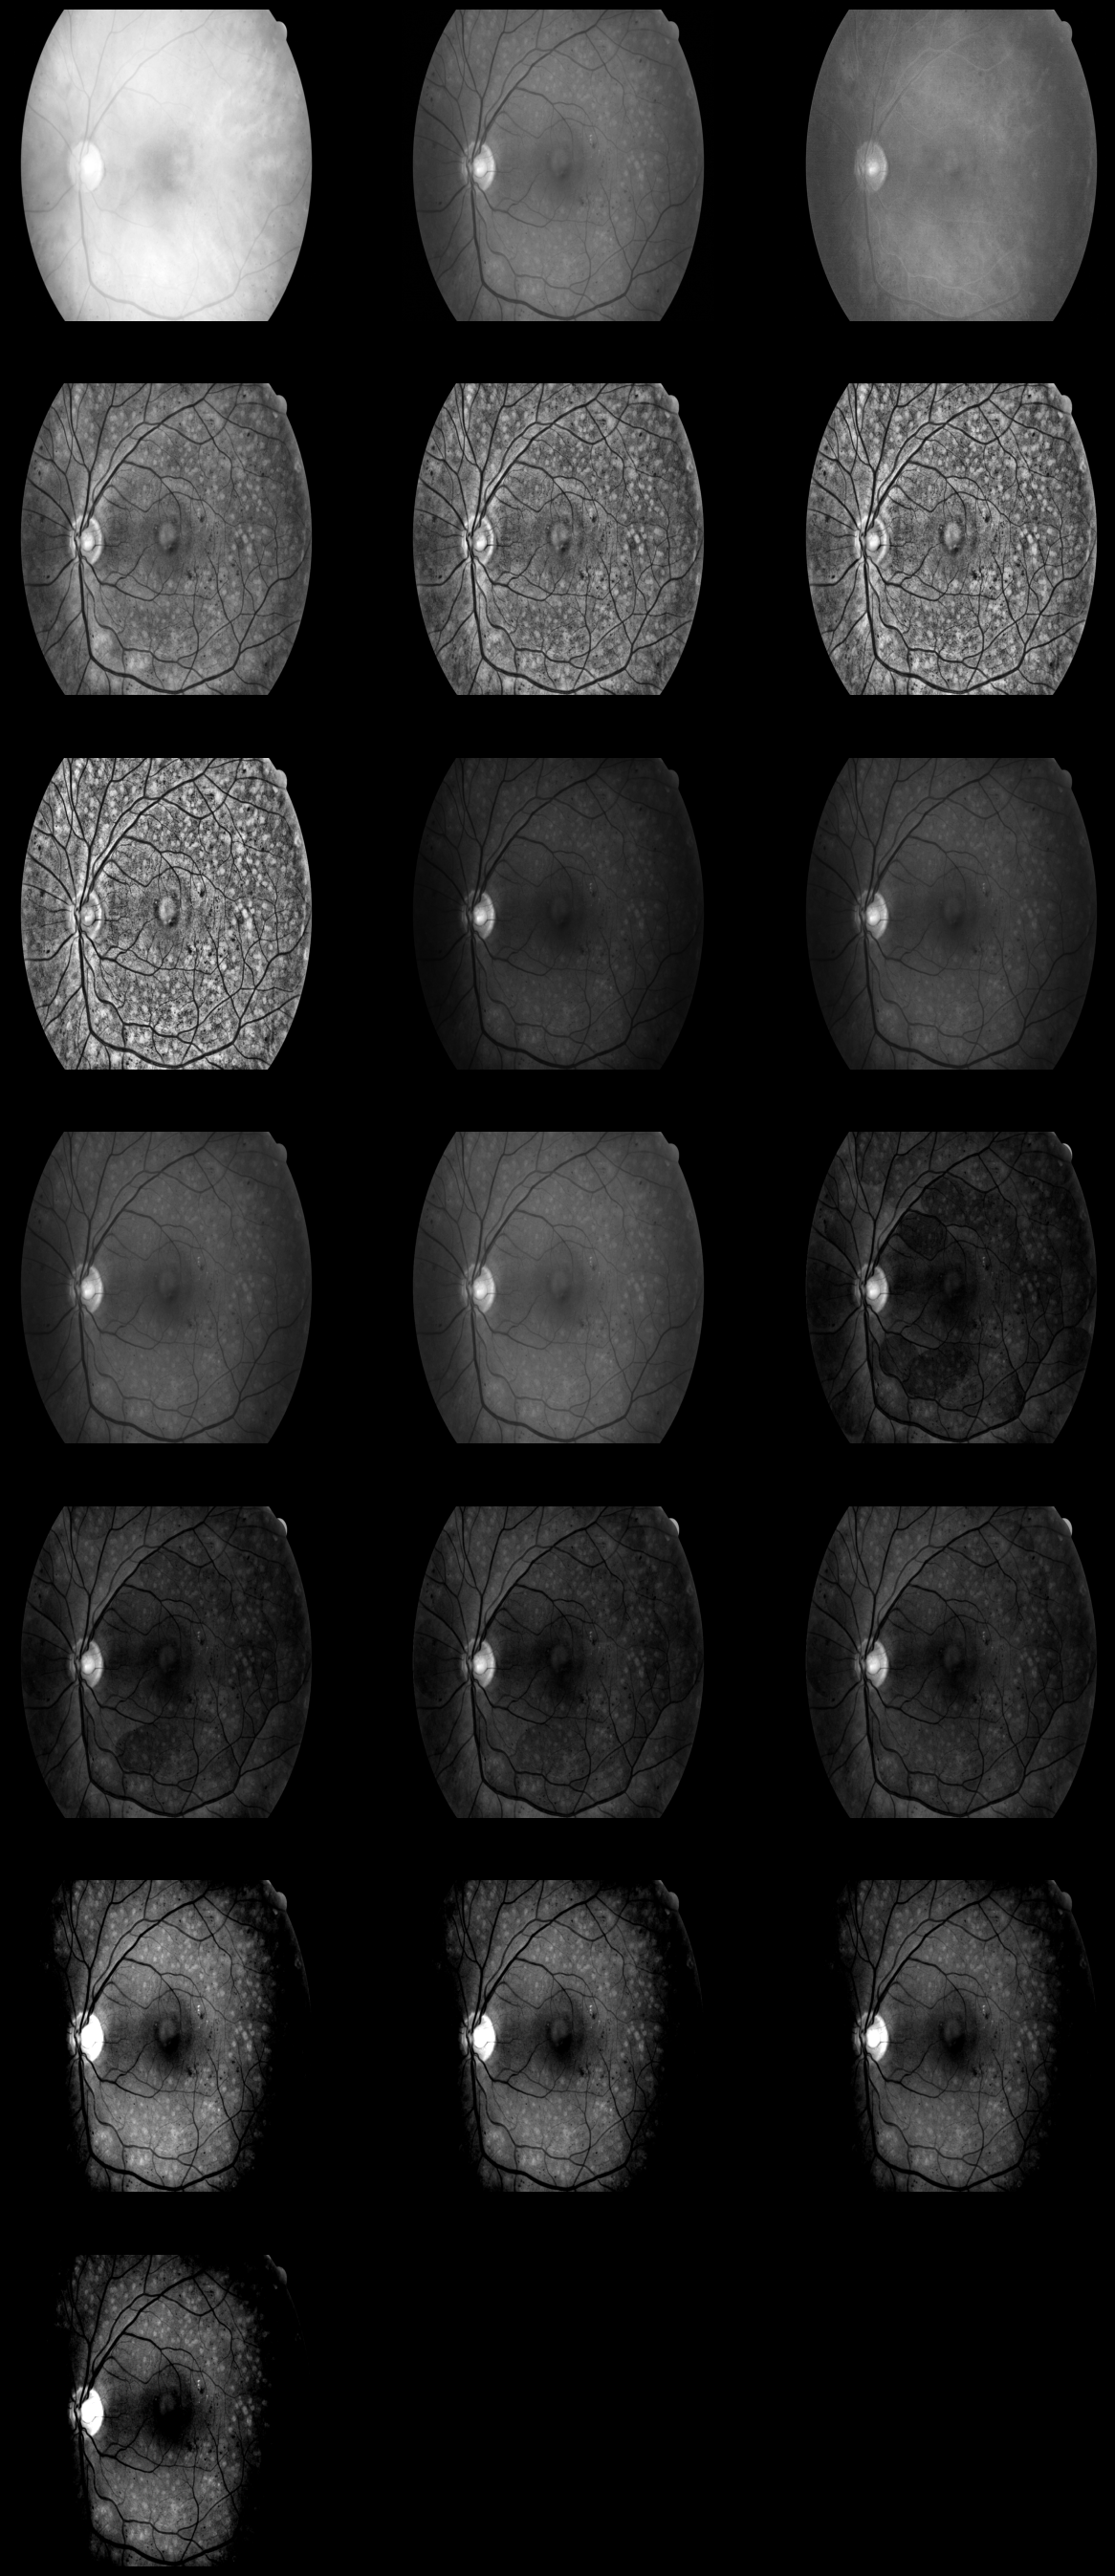

In [21]:
List = []
index = 0
num = 19
for i in range(num):
    List.append(val_images[index][...,i])

display_images(List,cmap = 'gray',size = 5,grid=(10,3))

## > Model Building & importing

### > get the base Models

In [22]:
# !pip install segmentation_models

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [23]:
# !pip install keras_unet_collection

In [24]:
# from keras_unet_collection import models as unet_models
# from keras_unet_collection import losses as unet_losses

In [25]:
config['dataset']['_image_shape'] = desired_shape

In [26]:
# num = 0
# model_name = Model_names[0]
# # backbone_name ='EfficientNetB0'
# # backbone_name ='efficientnetb0'

# image_shape =  config['dataset']['_image_shape'] 

In [27]:
import sys

sys.path.append(base_path + "my-unet-collection/MyKerasLiberary") 

import unet_models as unet_models

In [28]:
# num = 2
# model_name = Model_names[num]
# image_shape =  config['dataset']['_image_shape'] 
# n_channel = train_images[0].shape[-1]


# unet_models.General_Config['image_shape']= image_shape
# unet_models.General_Config['n_channel']= n_channel
# unet_models.Model_Config['n_level'] = 4
# unet_models.Model_Config['n_unit'] = 32
# unet_models.Model_Config['dilation'] = 1
# Model = unet_models.BuildUnet(num = num)

In [29]:
model_name = Model_names[4]
image_shape =  config['dataset']['_image_shape'] 
n_channel = train_images[0].shape[-1]


unet_models.General_Config['image_shape']= image_shape
unet_models.General_Config['n_channel']= n_channel
unet_models.Model_Config['n_level'] = 4
unet_models.Model_Config['n_unit'] = 32
unet_models.Model_Config['dilation'] = 1

Model = unet_models.BuildUnet(num = 0 , has_attention=True)

In [30]:
models.clone_model(Model)

<Functional name=Unet_Model, built=True>

In [31]:
Model.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 19)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1024,      │        640 │ input_layer[0][0] │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1024,      │      9,248 │ conv2d[0][0]      │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024,      │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1024,      │      9,248 │ activation[0][0]  │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 512, 512,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 256, 256,  │          0 │ activation_3[0][

 Total params: 8,392,805 (32.02 MB)

 Trainable params: 8,386,917 (31.99 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [32]:
# def get_segmentation_model_0():
#     n_class = 1
#     BaseModel = sm.Unet(backbone_name = backbone_name , 
#                                     input_shape = image_shape+(3,),
#                                     encoder_weights='imagenet',
#                                      classes=1,
#                                     activation = 'sigmoid',
#                                     encoder_freeze = True,
#                                     decoder_block_type ='upsampling',
#                                    )
#     return BaseModel
# def get_segmentation_model_1():
#     Model = unet_models.unet_2d(image_shape+(3,) ,
#                             n_labels = 1,
#                             filter_num=[32,64,128,256,512],
#                             output_activation='Sigmoid',
#                             weights='imagenet',
#                             # name = 'my_unet',
#                             batch_norm=True,
#                             backbone=backbone_name,
#                             freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_2():
#     Model = unet_models.r2_unet_2d(image_shape + (3,),
#                                n_labels = 1,
#                                 filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                 # name = 'my_unet',
#                                batch_norm=True,
#                                 # backbone='bacbackbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_3():
#     Model = unet_models.att_unet_2d(image_shape+(3,) ,
#                                n_labels = 1,
#                                filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                # name = 'my_unet',
#                                batch_norm=True,
            
#                                 # backbone = backbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_4():
#     Model = unet_models.unet_3plus_2d(
#                                 image_shape+(3,) ,
#                                 n_labels = 1,

#                                 filter_num_down=[32,64,128,256,512],
#                                 # filter_num_up=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                backbone='EfficientNetB0',
#                                weights='imagenet',
#                                 batch_norm=True,
#                                 # name = 'my_unet',
#                                 freeze_backbone=True,
#                                 filter_num_skip = [64,]*4,
#               )
#     return Model

### > build Model 

In [33]:
# sm.get_preprocessing(backbone_name)(image)

In [34]:
# Model = get_segmentation_model_0()
# Model.summary(100)

In [35]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# x_rescale = layers.Rescaling(1/255.)(fn_input)

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)
# x_add = layers.BatchNormalization()(x_add)

# fn_output = layers.Conv2D(1,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'sigmoid')(x6)

# # fn_output  = Model(x1)
# pre_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# pre_Model.summary(100)
# models.clone_model(pre_Model)

In [36]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel ,))

# x1 = layers.Conv2D(n_unit, kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x3  = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x_add = layers.Add()([x1,x2,x3]) 
# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)

# x_out = un_model_1(fn_input)
# x_conc =  layers.Concatenate()([x_out*255 , x_add])

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_conc)
# x6 = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same',dilation_rate = dilation ,kernel_initializer= 'ones',activation = 'relu')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs = x6,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [37]:
# n_unit = 8
# dilation = 2 
# n_channel = 13 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# # x_rescale = layers.Rescaling(1/255.)(fn_input)
# x_rescale = fn_input

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# # x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'relu')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# # x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# # x6 = layers.BatchNormalization()(x6)

# fn_output = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [38]:
# un_model_1 = pre_Model
# un_model_1.set_weights(Unet_Model.get_weights())

In [39]:
# un_model_2 = pre_Model
# un_model_2.set_weights(un_model_1.get_weights())

In [40]:
# Unet_Model = models.Sequential([prev_Model,Model])
# Unet_Model.summary()
# models.clone_model(Unet_Model)

In [41]:
# Unet_Model = pre_Model
# Unet_Model = Model

In [42]:
# Unet_Model(np.zeros(shape = (1,)+image_shape+ (28,))).shape

## > Model Training 

In [43]:
model_weights_path1 = 'unet_model_best1.weights.h5'
model_weights_path2 = 'unet_model_best2.weights.h5'
model_weights_path3 = 'unet_model_best3.weights.h5'
model_weights_path4 = 'unet_model_best4.weights.h5'
model_weights_path5 = 'unet_model_best5.weights.h5'
model_weights_path6 = 'unet_model_best6.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.6, ## reduce by this factor . ## lr = lr*0.1
    patience = 5, ## wait till these number of epochs ,
    verbose = 1,
    mode = 'auto', ## similar to what studied above,,i..e Min or Max..
    min_delta = 0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown = 0,  ## to wait after we have updated our lr ,,
    min_lr = 0, ## dont go below this lr.
)

In [44]:
# os.removedirs(base_path + 'liberary')

In [45]:
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# bce_loss = sm.losses.BinaryCELoss()
# jaccard_loss = sm.losses.JaccardLoss()
# hybrid_loss1 = dice_loss + 1.*(focal_loss)
# hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
# hybrid_loss3 = jaccard_loss + bce_loss
# # loss = dice_loss
# # loss = hybrid_loss1
# # loss = bce_loss
# # loss = focal_loss
loss = sm.losses.JaccardLoss()
# # loss = sm.losses.binary_focal_jaccard_loss
# # loss = hybrid_loss3

In [46]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    total_background = tf.keras.backend.sum(1 - y_true)
    return tn / (total_background + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float32'))
    total_foreground = tf.keras.backend.sum(y_true)
    return tp / (total_foreground + tf.keras.backend.epsilon())

# Assuming y_true and y_pred are segmentation masks with values in {0, 1} for background and foreground, respectively
# Compute specificity and sensitivity
# spec = specificity(y_true, y_pred)
# sens = sensitivity(y_true, y_pred)

In [47]:
metrics_ = [
            # metrics.MeanIoU(num_classes=2 , name = 'mean_iou_score') ,
            sm.metrics.IOUScore(name = 'iou_score',),
            'accuracy', 
            sm.metrics.FScore(name = 'f1score'),
            metrics.AUC(name = 'auc',),
            # metrics.BinaryIoU(name='binary_iou'),
            specificity,
            sensitivity
           ]

lr = 0.005
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [48]:
History = {}
def add_to_history(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

### Augmentatiion

In [49]:
transform = A.Compose(
    [
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
    ]
)

def Augment_it(X_train ,Y_train,rescale = False):
    Image_List = []
    Mask_List = []
    for image , mask  in zip(X_train,Y_train):
        Dict = { 'image':image,
                        'mask':mask ,}
        trans_data = transform(**Dict)
        
        Image_List.append(trans_data['image'])
        Mask_List.append(trans_data['mask'])
    
    Image_List = np.array(Image_List)         
    Mask_List = np.array(Mask_List)         
    
    if(rescale):
        Image_List/=255.
    return Image_List,Mask_List

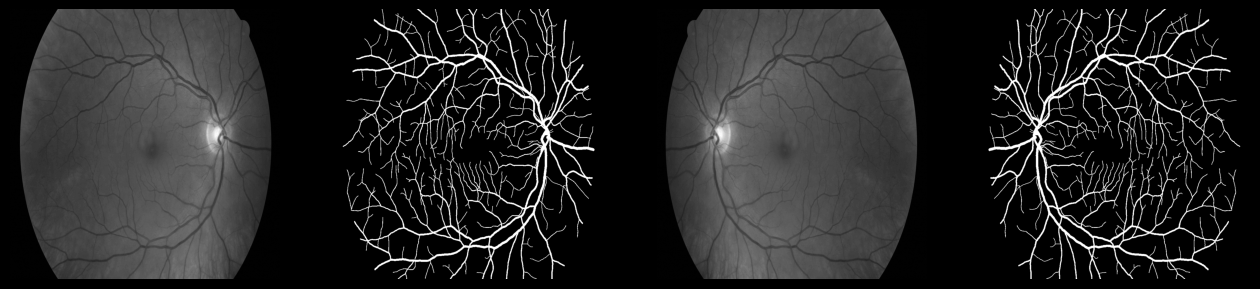

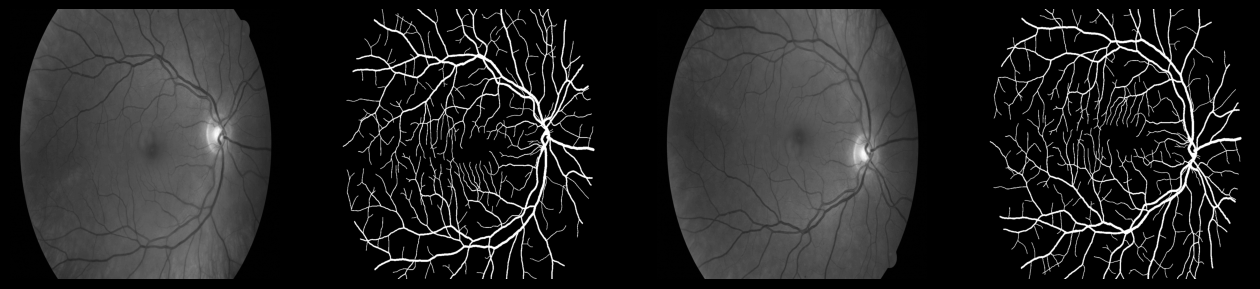

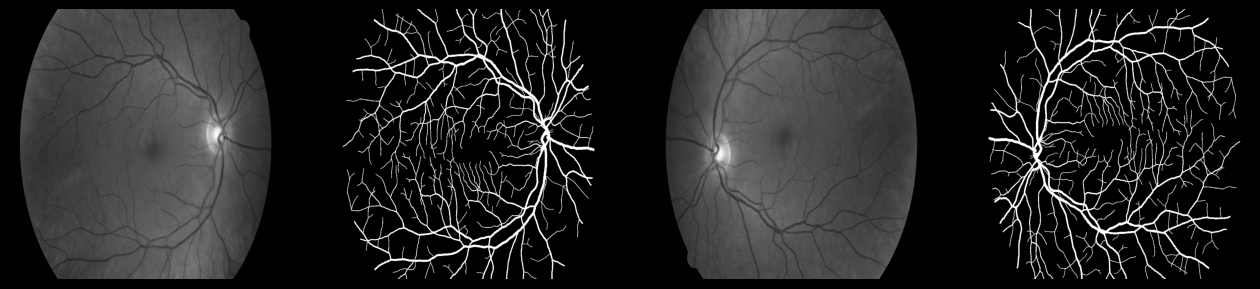

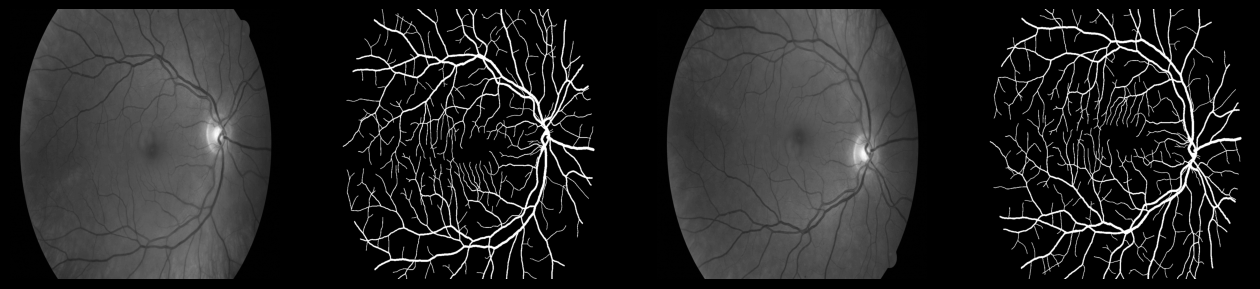

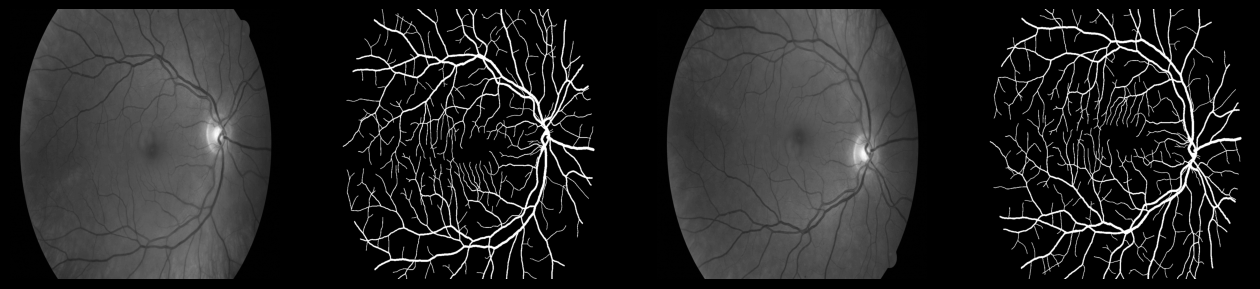

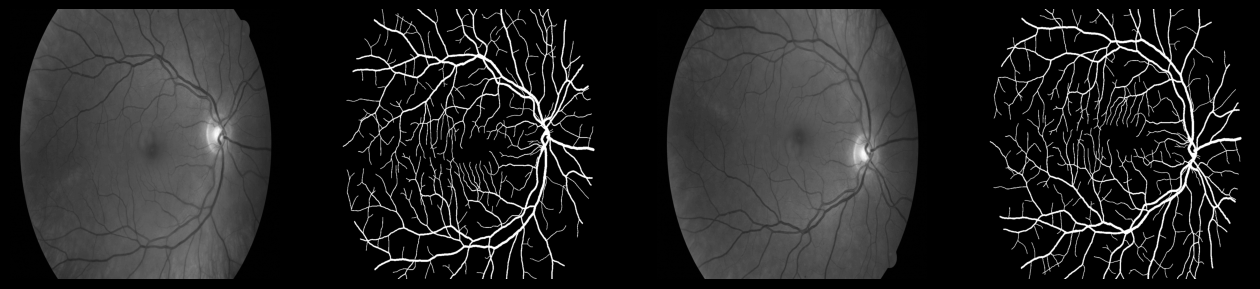

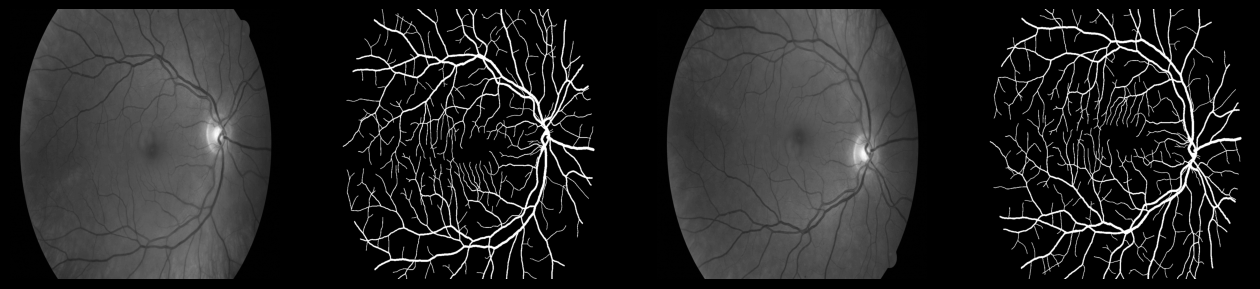

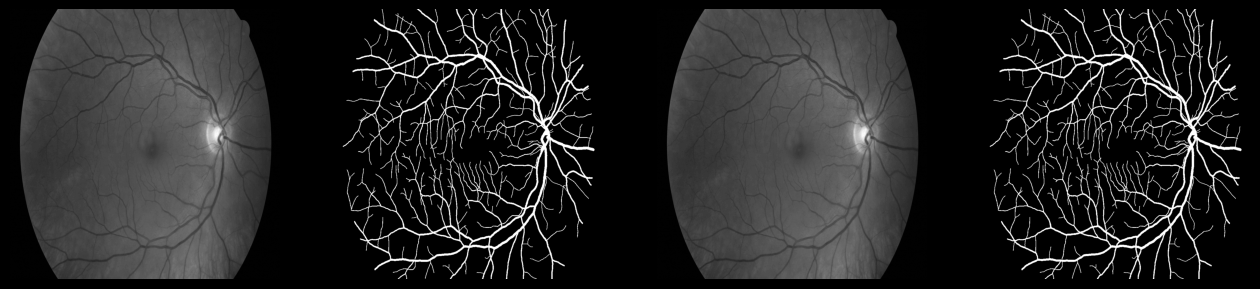

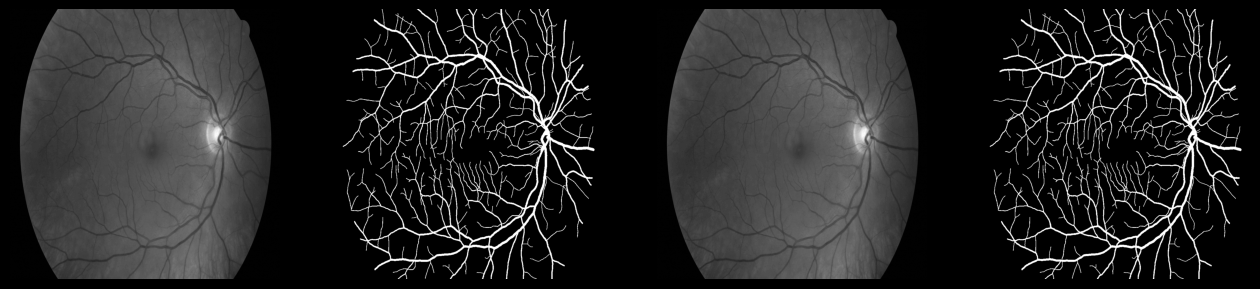

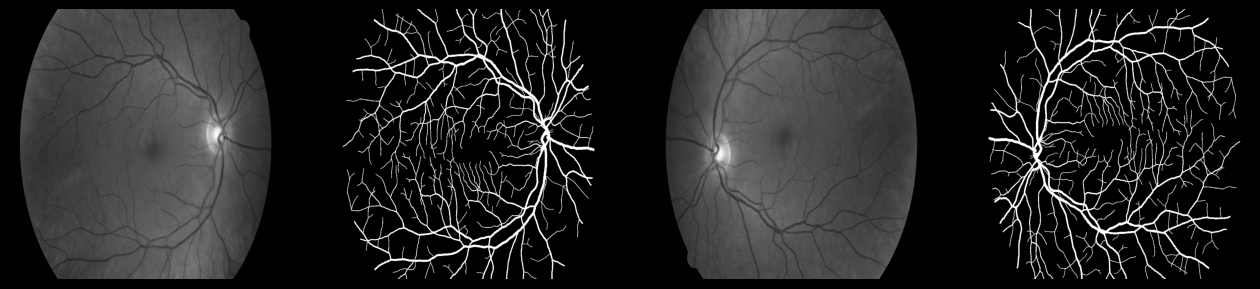

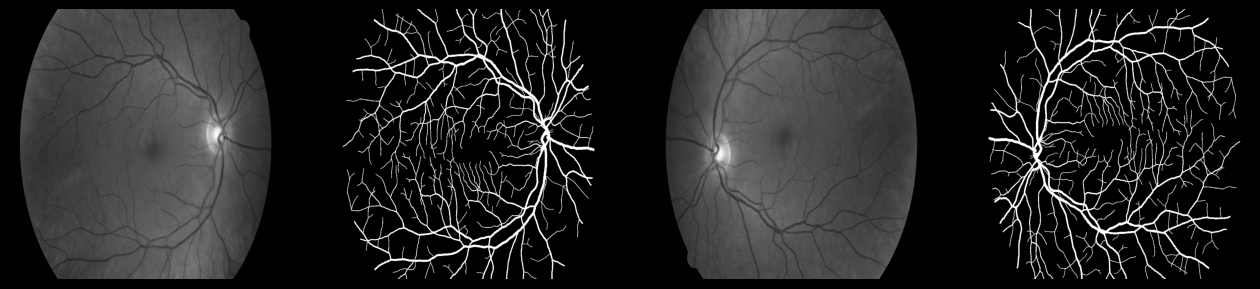

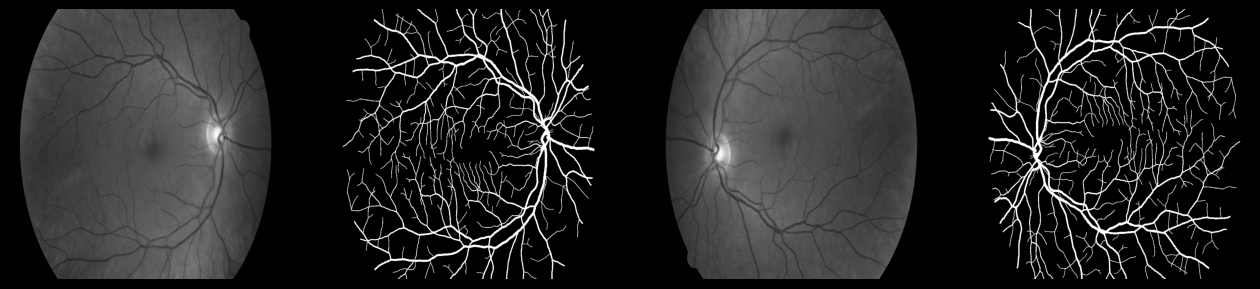

In [50]:
num_ = 12
index = 1
for i in range(num_):
    X_train,Y_train =Augment_it(train_images[:1],train_masks[:1])
    display_images([train_images[0][...,index],train_masks[0] ,X_train[0][...,index],Y_train[0]] ,size = 4,cmap = 'gray')

### Training

In [51]:
batch_size = 2

# back_bone_name =  'efficientnetb0' 
# preprocess = sm.get_preprocessing(back_bone_name)

indexes = np.arange(train_images.shape[0])
patience = 5
temp_wait = 0
factor = 0.5
lr_scale = 1.2
monitor = 'val_loss'
best_monitor_value = 1234647  

In [52]:
n_epoch = 150

for epoch in tqdm(range(n_epoch)):
    indexes = np.random.permutation(indexes)

    X_train ,Y_train = train_images[indexes] , train_masks[indexes] 
    X_train ,Y_train = Augment_it(X_train ,Y_train )
    
    ## preprocessing .......................................................................................................
    # X_train = preprocess(X_train)
    # X_val = preprocess(val_images)
    
    ## Plateau Callback .....................................................................................................
    if(monitor in History.keys()) :
        # print(temp_wait ,History[monitor][-1] , best_monitor_value)
        if (History[monitor][-1] < best_monitor_value):
            best_monitor_value = History[monitor] [-1]
            temp_wait = patience
        else:
            if(temp_wait > 0):
                temp_wait -= 1
            else:
                prev_lr =np.array(Model.optimizer.learning_rate)
                new_lr = (prev_lr) * factor
                setattr(Model.optimizer, 'learning_rate',new_lr)
                print(f">>>>>>>> | Changing Learning Rate from {prev_lr} to {new_lr}")
                
                patience = int(patience * lr_scale)
                temp_wait = patience
    print('>>>>>>>> | Learning is :', np.array(Model.optimizer.learning_rate),"| Patience is",patience ,'| temp_wait is',temp_wait)
    # ///----------------------------------------------------------------------------------------
    history = Model.fit(
                X_train,
                Y_train,
                
                validation_data=[val_images ,val_masks],
                epochs  = 1,
                batch_size = batch_size,
                callbacks=([checkpoint_callback , 
#                             plateau_callback,
                           ]
                        ),
                shuffle = False,
        
                )
    add_to_history(history)

  0%|          | 0/150 [00:00<?, ?it/s]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0


2024-05-12 20:47:43.499447: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 20:47:43.745932: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.246576725s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 20:47:45.801221: E exter

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7694 - auc: 0.8180 - f1score: 0.3758 - iou_score: 0.2427 - loss: 0.7577 - sensitivity: 0.7263 - specificity: 0.6725   
Epoch 1: val_loss improved from inf to 0.78715, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.7743 - auc: 0.8216 - f1score: 0.3839 - iou_score: 0.2497 - loss: 0.7510 - sensitivity: 0.7281 - specificity: 0.6800 - val_accuracy: 0.9255 - val_auc: 0.8377 - val_f1score: 0.3535 - val_iou_score: 0.2151 - val_loss: 0.7872 - val_sensitivity: 0.6264 - val_specificity: 0.7974


  1%|          | 1/150 [02:29<6:11:08, 149.45s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9433 - auc: 0.9065 - f1score: 0.7364 - iou_score: 0.5840 - loss: 0.4159 - sensitivity: 0.7165 - specificity: 0.9703
Epoch 1: val_loss did not improve from 0.78715
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.9434 - auc: 0.9063 - f1score: 0.7367 - iou_score: 0.5844 - loss: 0.4155 - sensitivity: 0.7173 - specificity: 0.9703 - val_accuracy: 0.5647 - val_auc: 0.7747 - val_f1score: 0.2902 - val_iou_score: 0.1701 - val_loss: 0.8305 - val_sensitivity: 0.9304 - val_specificity: 0.5252


  1%|▏         | 2/150 [02:44<2:53:08, 70.19s/it] 

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9440 - auc: 0.8905 - f1score: 0.7486 - iou_score: 0.5988 - loss: 0.4013 - sensitivity: 0.7361 - specificity: 0.9703
Epoch 1: val_loss improved from 0.78715 to 0.72389, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 786ms/step - accuracy: 0.9442 - auc: 0.8909 - f1score: 0.7494 - iou_score: 0.5998 - loss: 0.4005 - sensitivity: 0.7368 - specificity: 0.9704 - val_accuracy: 0.7750 - val_auc: 0.8976 - val_f1score: 0.4290 - val_iou_score: 0.2749 - val_loss: 0.7239 - val_sensitivity: 0.9061 - val_specificity: 0.7524


  2%|▏         | 3/150 [02:59<1:50:37, 45.15s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9485 - auc: 0.8953 - f1score: 0.7664 - iou_score: 0.6223 - loss: 0.3779 - sensitivity: 0.7537 - specificity: 0.9734
Epoch 1: val_loss improved from 0.72389 to 0.51471, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 806ms/step - accuracy: 0.9486 - auc: 0.8955 - f1score: 0.7670 - iou_score: 0.6231 - loss: 0.3773 - sensitivity: 0.7542 - specificity: 0.9734 - val_accuracy: 0.9193 - val_auc: 0.9134 - val_f1score: 0.6472 - val_iou_score: 0.4811 - val_loss: 0.5147 - val_sensitivity: 0.8120 - val_specificity: 0.9266


  3%|▎         | 4/150 [03:15<1:21:41, 33.57s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9484 - auc: 0.9061 - f1score: 0.7727 - iou_score: 0.6303 - loss: 0.3699 - sensitivity: 0.7815 - specificity: 0.9692
Epoch 1: val_loss did not improve from 0.51471
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9485 - auc: 0.9060 - f1score: 0.7732 - iou_score: 0.6311 - loss: 0.3693 - sensitivity: 0.7814 - specificity: 0.9694 - val_accuracy: 0.7851 - val_auc: 0.8852 - val_f1score: 0.4482 - val_iou_score: 0.2913 - val_loss: 0.7098 - val_sensitivity: 0.9131 - val_specificity: 0.7683


  3%|▎         | 5/150 [03:30<1:05:01, 26.90s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9538 - auc: 0.9143 - f1score: 0.7999 - iou_score: 0.6672 - loss: 0.3328 - sensitivity: 0.7960 - specificity: 0.9744
Epoch 1: val_loss did not improve from 0.51471
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 733ms/step - accuracy: 0.9537 - auc: 0.9139 - f1score: 0.7993 - iou_score: 0.6665 - loss: 0.3335 - sensitivity: 0.7954 - specificity: 0.9745 - val_accuracy: 0.7536 - val_auc: 0.8845 - val_f1score: 0.4169 - val_iou_score: 0.2651 - val_loss: 0.7295 - val_sensitivity: 0.9449 - val_specificity: 0.7232


  4%|▍         | 6/150 [03:45<54:38, 22.77s/it]  

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9530 - auc: 0.9024 - f1score: 0.7897 - iou_score: 0.6535 - loss: 0.3464 - sensitivity: 0.7713 - specificity: 0.9765
Epoch 1: val_loss did not improve from 0.51471
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 731ms/step - accuracy: 0.9531 - auc: 0.9027 - f1score: 0.7900 - iou_score: 0.6540 - loss: 0.3459 - sensitivity: 0.7720 - specificity: 0.9765 - val_accuracy: 0.8519 - val_auc: 0.9139 - val_f1score: 0.5394 - val_iou_score: 0.3706 - val_loss: 0.6284 - val_sensitivity: 0.9210 - val_specificity: 0.8423


  5%|▍         | 7/150 [03:59<48:00, 20.15s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9572 - auc: 0.9223 - f1score: 0.8163 - iou_score: 0.6905 - loss: 0.3094 - sensitivity: 0.8156 - specificity: 0.9758
Epoch 1: val_loss improved from 0.51471 to 0.48084, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.9571 - auc: 0.9219 - f1score: 0.8155 - iou_score: 0.6894 - loss: 0.3105 - sensitivity: 0.8148 - specificity: 0.9757 - val_accuracy: 0.9270 - val_auc: 0.9162 - val_f1score: 0.6691 - val_iou_score: 0.5054 - val_loss: 0.4808 - val_sensitivity: 0.8363 - val_specificity: 0.9286


  5%|▌         | 8/150 [04:15<44:04, 18.63s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9533 - auc: 0.9030 - f1score: 0.7866 - iou_score: 0.6494 - loss: 0.3508 - sensitivity: 0.7800 - specificity: 0.9748
Epoch 1: val_loss improved from 0.48084 to 0.42324, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 778ms/step - accuracy: 0.9535 - auc: 0.9037 - f1score: 0.7879 - iou_score: 0.6512 - loss: 0.3492 - sensitivity: 0.7816 - specificity: 0.9748 - val_accuracy: 0.9409 - val_auc: 0.9243 - val_f1score: 0.7215 - val_iou_score: 0.5669 - val_loss: 0.4232 - val_sensitivity: 0.8483 - val_specificity: 0.9470


  6%|▌         | 9/150 [04:30<41:29, 17.65s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9568 - auc: 0.9109 - f1score: 0.8071 - iou_score: 0.6780 - loss: 0.3219 - sensitivity: 0.7960 - specificity: 0.9776
Epoch 1: val_loss did not improve from 0.42324
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9568 - auc: 0.9111 - f1score: 0.8072 - iou_score: 0.6782 - loss: 0.3217 - sensitivity: 0.7962 - specificity: 0.9776 - val_accuracy: 0.9158 - val_auc: 0.9341 - val_f1score: 0.6562 - val_iou_score: 0.4926 - val_loss: 0.4904 - val_sensitivity: 0.9056 - val_specificity: 0.9076


  7%|▋         | 10/150 [04:45<39:16, 16.83s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9553 - auc: 0.9130 - f1score: 0.7950 - iou_score: 0.6604 - loss: 0.3396 - sensitivity: 0.8069 - specificity: 0.9732
Epoch 1: val_loss did not improve from 0.42324
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step - accuracy: 0.9555 - auc: 0.9132 - f1score: 0.7959 - iou_score: 0.6617 - loss: 0.3383 - sensitivity: 0.8069 - specificity: 0.9734 - val_accuracy: 0.8924 - val_auc: 0.9171 - val_f1score: 0.6002 - val_iou_score: 0.4340 - val_loss: 0.5426 - val_sensitivity: 0.9011 - val_specificity: 0.8755


  7%|▋         | 11/150 [05:00<37:34, 16.22s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9562 - auc: 0.9256 - f1score: 0.8118 - iou_score: 0.6852 - loss: 0.3148 - sensitivity: 0.8333 - specificity: 0.9717
Epoch 1: val_loss improved from 0.42324 to 0.36934, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - accuracy: 0.9563 - auc: 0.9254 - f1score: 0.8119 - iou_score: 0.6854 - loss: 0.3146 - sensitivity: 0.8328 - specificity: 0.9718 - val_accuracy: 0.9582 - val_auc: 0.8977 - val_f1score: 0.7628 - val_iou_score: 0.6190 - val_loss: 0.3693 - val_sensitivity: 0.7575 - val_specificity: 0.9759


  8%|▊         | 12/150 [05:15<36:34, 15.90s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9589 - auc: 0.9182 - f1score: 0.8221 - iou_score: 0.6990 - loss: 0.3010 - sensitivity: 0.8103 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.36934
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9589 - auc: 0.9182 - f1score: 0.8217 - iou_score: 0.6984 - loss: 0.3016 - sensitivity: 0.8103 - specificity: 0.9786 - val_accuracy: 0.9561 - val_auc: 0.8804 - val_f1score: 0.7414 - val_iou_score: 0.5907 - val_loss: 0.4044 - val_sensitivity: 0.7073 - val_specificity: 0.9790


  9%|▊         | 13/150 [05:30<35:32, 15.56s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9597 - auc: 0.9194 - f1score: 0.8200 - iou_score: 0.6958 - loss: 0.3044 - sensitivity: 0.8114 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.36934
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.9596 - auc: 0.9195 - f1score: 0.8199 - iou_score: 0.6956 - loss: 0.3046 - sensitivity: 0.8118 - specificity: 0.9785 - val_accuracy: 0.9498 - val_auc: 0.9090 - val_f1score: 0.7337 - val_iou_score: 0.5859 - val_loss: 0.3887 - val_sensitivity: 0.8034 - val_specificity: 0.9560


  9%|▉         | 14/150 [05:45<34:49, 15.36s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9599 - auc: 0.9203 - f1score: 0.8194 - iou_score: 0.6945 - loss: 0.3053 - sensitivity: 0.8149 - specificity: 0.9781
Epoch 1: val_loss improved from 0.36934 to 0.35493, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 777ms/step - accuracy: 0.9599 - auc: 0.9205 - f1score: 0.8195 - iou_score: 0.6947 - loss: 0.3050 - sensitivity: 0.8153 - specificity: 0.9781 - val_accuracy: 0.9570 - val_auc: 0.9195 - val_f1score: 0.7719 - val_iou_score: 0.6315 - val_loss: 0.3549 - val_sensitivity: 0.8269 - val_specificity: 0.9662


 10%|█         | 15/150 [06:00<34:31, 15.35s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9611 - auc: 0.9214 - f1score: 0.8236 - iou_score: 0.7006 - loss: 0.2993 - sensitivity: 0.8201 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.35493
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9610 - auc: 0.9214 - f1score: 0.8235 - iou_score: 0.7006 - loss: 0.2993 - sensitivity: 0.8200 - specificity: 0.9788 - val_accuracy: 0.9568 - val_auc: 0.8993 - val_f1score: 0.7618 - val_iou_score: 0.6180 - val_loss: 0.3698 - val_sensitivity: 0.7798 - val_specificity: 0.9713


 11%|█         | 16/150 [06:15<34:03, 15.25s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9597 - auc: 0.9201 - f1score: 0.8177 - iou_score: 0.6920 - loss: 0.3080 - sensitivity: 0.8218 - specificity: 0.9769
Epoch 1: val_loss did not improve from 0.35493
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9597 - auc: 0.9201 - f1score: 0.8181 - iou_score: 0.6926 - loss: 0.3074 - sensitivity: 0.8219 - specificity: 0.9769 - val_accuracy: 0.9546 - val_auc: 0.9173 - val_f1score: 0.7604 - val_iou_score: 0.6186 - val_loss: 0.3596 - val_sensitivity: 0.8294 - val_specificity: 0.9609


 11%|█▏        | 17/150 [06:30<33:45, 15.23s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9613 - auc: 0.9260 - f1score: 0.8304 - iou_score: 0.7107 - loss: 0.2894 - sensitivity: 0.8314 - specificity: 0.9782
Epoch 1: val_loss improved from 0.35493 to 0.33527, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9613 - auc: 0.9259 - f1score: 0.8303 - iou_score: 0.7104 - loss: 0.2898 - sensitivity: 0.8313 - specificity: 0.9782 - val_accuracy: 0.9611 - val_auc: 0.9177 - val_f1score: 0.7905 - val_iou_score: 0.6557 - val_loss: 0.3353 - val_sensitivity: 0.8182 - val_specificity: 0.9735


 12%|█▏        | 18/150 [06:46<33:41, 15.32s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9618 - auc: 0.9223 - f1score: 0.8279 - iou_score: 0.7074 - loss: 0.2925 - sensitivity: 0.8215 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.33527
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9618 - auc: 0.9222 - f1score: 0.8277 - iou_score: 0.7072 - loss: 0.2927 - sensitivity: 0.8215 - specificity: 0.9796 - val_accuracy: 0.9432 - val_auc: 0.9268 - val_f1score: 0.7272 - val_iou_score: 0.5791 - val_loss: 0.3925 - val_sensitivity: 0.8699 - val_specificity: 0.9406


 13%|█▎        | 19/150 [07:01<33:03, 15.14s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9576 - auc: 0.9222 - f1score: 0.8167 - iou_score: 0.6909 - loss: 0.3091 - sensitivity: 0.8330 - specificity: 0.9735
Epoch 1: val_loss did not improve from 0.33527
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step - accuracy: 0.9577 - auc: 0.9223 - f1score: 0.8173 - iou_score: 0.6917 - loss: 0.3083 - sensitivity: 0.8329 - specificity: 0.9738 - val_accuracy: 0.9555 - val_auc: 0.9177 - val_f1score: 0.7698 - val_iou_score: 0.6284 - val_loss: 0.3588 - val_sensitivity: 0.8339 - val_specificity: 0.9646


 13%|█▎        | 20/150 [07:16<32:38, 15.06s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9608 - auc: 0.9262 - f1score: 0.8310 - iou_score: 0.7115 - loss: 0.2885 - sensitivity: 0.8389 - specificity: 0.9769
Epoch 1: val_loss did not improve from 0.33527
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9608 - auc: 0.9261 - f1score: 0.8309 - iou_score: 0.7113 - loss: 0.2888 - sensitivity: 0.8384 - specificity: 0.9770 - val_accuracy: 0.9611 - val_auc: 0.9031 - val_f1score: 0.7847 - val_iou_score: 0.6476 - val_loss: 0.3447 - val_sensitivity: 0.7843 - val_specificity: 0.9775


 14%|█▍        | 21/150 [07:30<32:13, 14.99s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9623 - auc: 0.9262 - f1score: 0.8292 - iou_score: 0.7088 - loss: 0.2913 - sensitivity: 0.8367 - specificity: 0.9778
Epoch 1: val_loss did not improve from 0.33527
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9622 - auc: 0.9261 - f1score: 0.8293 - iou_score: 0.7090 - loss: 0.2912 - sensitivity: 0.8363 - specificity: 0.9779 - val_accuracy: 0.9596 - val_auc: 0.9119 - val_f1score: 0.7817 - val_iou_score: 0.6442 - val_loss: 0.3439 - val_sensitivity: 0.8146 - val_specificity: 0.9711


 15%|█▍        | 22/150 [07:45<31:50, 14.93s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9598 - auc: 0.9267 - f1score: 0.8282 - iou_score: 0.7082 - loss: 0.2920 - sensitivity: 0.8402 - specificity: 0.9754
Epoch 1: val_loss did not improve from 0.33527
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9598 - auc: 0.9264 - f1score: 0.8281 - iou_score: 0.7080 - loss: 0.2923 - sensitivity: 0.8395 - specificity: 0.9755 - val_accuracy: 0.9598 - val_auc: 0.9031 - val_f1score: 0.7779 - val_iou_score: 0.6390 - val_loss: 0.3481 - val_sensitivity: 0.7914 - val_specificity: 0.9739


 15%|█▌        | 23/150 [08:00<31:35, 14.92s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9609 - auc: 0.9264 - f1score: 0.8293 - iou_score: 0.7092 - loss: 0.2907 - sensitivity: 0.8403 - specificity: 0.9765
Epoch 1: val_loss improved from 0.33527 to 0.33272, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9609 - auc: 0.9264 - f1score: 0.8292 - iou_score: 0.7091 - loss: 0.2908 - sensitivity: 0.8401 - specificity: 0.9765 - val_accuracy: 0.9615 - val_auc: 0.9150 - val_f1score: 0.7910 - val_iou_score: 0.6565 - val_loss: 0.3327 - val_sensitivity: 0.8149 - val_specificity: 0.9740


 16%|█▌        | 24/150 [08:15<31:34, 15.03s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9632 - auc: 0.9272 - f1score: 0.8371 - iou_score: 0.7205 - loss: 0.2794 - sensitivity: 0.8381 - specificity: 0.9792
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 739ms/step - accuracy: 0.9631 - auc: 0.9270 - f1score: 0.8368 - iou_score: 0.7200 - loss: 0.2798 - sensitivity: 0.8378 - specificity: 0.9792 - val_accuracy: 0.9573 - val_auc: 0.9151 - val_f1score: 0.7701 - val_iou_score: 0.6303 - val_loss: 0.3506 - val_sensitivity: 0.8179 - val_specificity: 0.9662


 17%|█▋        | 25/150 [08:30<31:11, 14.97s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9620 - auc: 0.9238 - f1score: 0.8277 - iou_score: 0.7070 - loss: 0.2929 - sensitivity: 0.8302 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9620 - auc: 0.9238 - f1score: 0.8277 - iou_score: 0.7070 - loss: 0.2928 - sensitivity: 0.8304 - specificity: 0.9784 - val_accuracy: 0.9561 - val_auc: 0.9164 - val_f1score: 0.7674 - val_iou_score: 0.6268 - val_loss: 0.3547 - val_sensitivity: 0.8280 - val_specificity: 0.9640


 17%|█▋        | 26/150 [08:45<30:57, 14.98s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9610 - auc: 0.9195 - f1score: 0.8243 - iou_score: 0.7017 - loss: 0.2984 - sensitivity: 0.8253 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9610 - auc: 0.9195 - f1score: 0.8246 - iou_score: 0.7021 - loss: 0.2982 - sensitivity: 0.8252 - specificity: 0.9781 - val_accuracy: 0.9564 - val_auc: 0.8940 - val_f1score: 0.7652 - val_iou_score: 0.6217 - val_loss: 0.3690 - val_sensitivity: 0.7921 - val_specificity: 0.9703


 18%|█▊        | 27/150 [09:00<30:41, 14.97s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9599 - auc: 0.9228 - f1score: 0.8198 - iou_score: 0.6951 - loss: 0.3051 - sensitivity: 0.8354 - specificity: 0.9752
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9600 - auc: 0.9228 - f1score: 0.8206 - iou_score: 0.6963 - loss: 0.3041 - sensitivity: 0.8351 - specificity: 0.9754 - val_accuracy: 0.9520 - val_auc: 0.9139 - val_f1score: 0.7528 - val_iou_score: 0.6086 - val_loss: 0.3696 - val_sensitivity: 0.8360 - val_specificity: 0.9571


 19%|█▊        | 28/150 [09:15<30:24, 14.95s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9610 - auc: 0.9310 - f1score: 0.8337 - iou_score: 0.7158 - loss: 0.2842 - sensitivity: 0.8541 - specificity: 0.9749
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9611 - auc: 0.9308 - f1score: 0.8335 - iou_score: 0.7156 - loss: 0.2843 - sensitivity: 0.8537 - specificity: 0.9750 - val_accuracy: 0.9588 - val_auc: 0.8991 - val_f1score: 0.7712 - val_iou_score: 0.6310 - val_loss: 0.3528 - val_sensitivity: 0.7871 - val_specificity: 0.9721


 19%|█▉        | 29/150 [09:30<30:02, 14.89s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9627 - auc: 0.9217 - f1score: 0.8383 - iou_score: 0.7220 - loss: 0.2779 - sensitivity: 0.8265 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9627 - auc: 0.9218 - f1score: 0.8380 - iou_score: 0.7216 - loss: 0.2783 - sensitivity: 0.8268 - specificity: 0.9808 - val_accuracy: 0.9600 - val_auc: 0.8984 - val_f1score: 0.7769 - val_iou_score: 0.6378 - val_loss: 0.3518 - val_sensitivity: 0.7844 - val_specificity: 0.9748


 20%|██        | 30/150 [09:45<29:47, 14.89s/it]

>>>>>>>> | Changing Learning Rate from 0.004999999888241291 to 0.0024999999441206455
>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9626 - auc: 0.9214 - f1score: 0.8332 - iou_score: 0.7151 - loss: 0.2849 - sensitivity: 0.8274 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.33272
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9626 - auc: 0.9216 - f1score: 0.8332 - iou_score: 0.7152 - loss: 0.2849 - sensitivity: 0.8277 - specificity: 0.9800 - val_accuracy: 0.9608 - val_auc: 0.9185 - val_f1score: 0.7918 - val_iou_score: 0.6575 - val_loss: 0.3328 - val_sensitivity: 0.8333 - val_specificity: 0.9712


 21%|██        | 31/150 [10:00<29:37, 14.94s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9622 - auc: 0.9297 - f1score: 0.8340 - iou_score: 0.7160 - loss: 0.2840 - sensitivity: 0.8502 - specificity: 0.9763
Epoch 1: val_loss improved from 0.33272 to 0.32775, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9622 - auc: 0.9295 - f1score: 0.8342 - iou_score: 0.7163 - loss: 0.2838 - sensitivity: 0.8497 - specificity: 0.9765 - val_accuracy: 0.9626 - val_auc: 0.9125 - val_f1score: 0.7958 - val_iou_score: 0.6630 - val_loss: 0.3278 - val_sensitivity: 0.8132 - val_specificity: 0.9756


 21%|██▏       | 32/150 [10:15<29:40, 15.09s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9628 - auc: 0.9274 - f1score: 0.8362 - iou_score: 0.7192 - loss: 0.2807 - sensitivity: 0.8443 - specificity: 0.9779
Epoch 1: val_loss improved from 0.32775 to 0.32655, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9628 - auc: 0.9274 - f1score: 0.8362 - iou_score: 0.7193 - loss: 0.2806 - sensitivity: 0.8443 - specificity: 0.9779 - val_accuracy: 0.9632 - val_auc: 0.9093 - val_f1score: 0.7982 - val_iou_score: 0.6658 - val_loss: 0.3266 - val_sensitivity: 0.8055 - val_specificity: 0.9776


 22%|██▏       | 33/150 [10:31<29:31, 15.14s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9625 - auc: 0.9249 - f1score: 0.8338 - iou_score: 0.7155 - loss: 0.2847 - sensitivity: 0.8400 - specificity: 0.9780
Epoch 1: val_loss did not improve from 0.32655
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9625 - auc: 0.9249 - f1score: 0.8341 - iou_score: 0.7159 - loss: 0.2844 - sensitivity: 0.8399 - specificity: 0.9781 - val_accuracy: 0.9609 - val_auc: 0.9182 - val_f1score: 0.7898 - val_iou_score: 0.6554 - val_loss: 0.3303 - val_sensitivity: 0.8298 - val_specificity: 0.9708


 23%|██▎       | 34/150 [10:45<29:10, 15.09s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9636 - auc: 0.9285 - f1score: 0.8393 - iou_score: 0.7236 - loss: 0.2764 - sensitivity: 0.8467 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.32655
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9636 - auc: 0.9285 - f1score: 0.8393 - iou_score: 0.7236 - loss: 0.2764 - sensitivity: 0.8466 - specificity: 0.9784 - val_accuracy: 0.9620 - val_auc: 0.9147 - val_f1score: 0.7935 - val_iou_score: 0.6601 - val_loss: 0.3281 - val_sensitivity: 0.8192 - val_specificity: 0.9738


 23%|██▎       | 35/150 [11:00<28:51, 15.06s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9617 - auc: 0.9184 - f1score: 0.8286 - iou_score: 0.7081 - loss: 0.2918 - sensitivity: 0.8244 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.32655
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 740ms/step - accuracy: 0.9618 - auc: 0.9188 - f1score: 0.8291 - iou_score: 0.7089 - loss: 0.2909 - sensitivity: 0.8251 - specificity: 0.9791 - val_accuracy: 0.9618 - val_auc: 0.9181 - val_f1score: 0.7939 - val_iou_score: 0.6607 - val_loss: 0.3271 - val_sensitivity: 0.8272 - val_specificity: 0.9726


 24%|██▍       | 36/150 [11:16<28:37, 15.07s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9610 - auc: 0.9238 - f1score: 0.8299 - iou_score: 0.7106 - loss: 0.2894 - sensitivity: 0.8379 - specificity: 0.9769
Epoch 1: val_loss improved from 0.32655 to 0.32615, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 772ms/step - accuracy: 0.9612 - auc: 0.9241 - f1score: 0.8303 - iou_score: 0.7111 - loss: 0.2887 - sensitivity: 0.8384 - specificity: 0.9769 - val_accuracy: 0.9623 - val_auc: 0.9162 - val_f1score: 0.7955 - val_iou_score: 0.6626 - val_loss: 0.3262 - val_sensitivity: 0.8219 - val_specificity: 0.9739


 25%|██▍       | 37/150 [11:31<28:33, 15.16s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9636 - auc: 0.9229 - f1score: 0.8404 - iou_score: 0.7251 - loss: 0.2749 - sensitivity: 0.8318 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.32615
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9636 - auc: 0.9230 - f1score: 0.8402 - iou_score: 0.7248 - loss: 0.2751 - sensitivity: 0.8320 - specificity: 0.9809 - val_accuracy: 0.9591 - val_auc: 0.9190 - val_f1score: 0.7819 - val_iou_score: 0.6458 - val_loss: 0.3353 - val_sensitivity: 0.8366 - val_specificity: 0.9669


 25%|██▌       | 38/150 [11:46<28:04, 15.04s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9626 - auc: 0.9267 - f1score: 0.8346 - iou_score: 0.7173 - loss: 0.2829 - sensitivity: 0.8438 - specificity: 0.9778
Epoch 1: val_loss improved from 0.32615 to 0.32479, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - accuracy: 0.9626 - auc: 0.9268 - f1score: 0.8349 - iou_score: 0.7176 - loss: 0.2826 - sensitivity: 0.8441 - specificity: 0.9779 - val_accuracy: 0.9636 - val_auc: 0.9075 - val_f1score: 0.7989 - val_iou_score: 0.6668 - val_loss: 0.3248 - val_sensitivity: 0.8015 - val_specificity: 0.9784


 26%|██▌       | 39/150 [12:01<28:01, 15.15s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9637 - auc: 0.9228 - f1score: 0.8396 - iou_score: 0.7241 - loss: 0.2759 - sensitivity: 0.8322 - specificity: 0.9808
Epoch 1: val_loss improved from 0.32479 to 0.32050, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9637 - auc: 0.9230 - f1score: 0.8395 - iou_score: 0.7239 - loss: 0.2759 - sensitivity: 0.8326 - specificity: 0.9807 - val_accuracy: 0.9628 - val_auc: 0.9188 - val_f1score: 0.8006 - val_iou_score: 0.6695 - val_loss: 0.3205 - val_sensitivity: 0.8313 - val_specificity: 0.9741


 27%|██▋       | 40/150 [12:17<27:59, 15.27s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9636 - auc: 0.9258 - f1score: 0.8414 - iou_score: 0.7269 - loss: 0.2732 - sensitivity: 0.8391 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.32050
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.9636 - auc: 0.9258 - f1score: 0.8413 - iou_score: 0.7267 - loss: 0.2735 - sensitivity: 0.8391 - specificity: 0.9801 - val_accuracy: 0.9633 - val_auc: 0.9020 - val_f1score: 0.7943 - val_iou_score: 0.6607 - val_loss: 0.3305 - val_sensitivity: 0.7867 - val_specificity: 0.9795


 27%|██▋       | 41/150 [12:32<27:32, 15.16s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9626 - auc: 0.9238 - f1score: 0.8281 - iou_score: 0.7072 - loss: 0.2928 - sensitivity: 0.8386 - specificity: 0.9776
Epoch 1: val_loss did not improve from 0.32050
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9627 - auc: 0.9240 - f1score: 0.8287 - iou_score: 0.7081 - loss: 0.2919 - sensitivity: 0.8388 - specificity: 0.9776 - val_accuracy: 0.9596 - val_auc: 0.9227 - val_f1score: 0.7866 - val_iou_score: 0.6515 - val_loss: 0.3329 - val_sensitivity: 0.8445 - val_specificity: 0.9674


 28%|██▊       | 42/150 [12:47<27:10, 15.10s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9620 - auc: 0.9273 - f1score: 0.8355 - iou_score: 0.7180 - loss: 0.2821 - sensitivity: 0.8471 - specificity: 0.9769
Epoch 1: val_loss improved from 0.32050 to 0.31816, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9621 - auc: 0.9273 - f1score: 0.8357 - iou_score: 0.7184 - loss: 0.2819 - sensitivity: 0.8468 - specificity: 0.9771 - val_accuracy: 0.9647 - val_auc: 0.9114 - val_f1score: 0.8065 - val_iou_score: 0.6773 - val_loss: 0.3182 - val_sensitivity: 0.8044 - val_specificity: 0.9801


 29%|██▊       | 43/150 [13:02<27:04, 15.19s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9631 - auc: 0.9267 - f1score: 0.8370 - iou_score: 0.7204 - loss: 0.2795 - sensitivity: 0.8434 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9632 - auc: 0.9266 - f1score: 0.8369 - iou_score: 0.7203 - loss: 0.2794 - sensitivity: 0.8431 - specificity: 0.9784 - val_accuracy: 0.9647 - val_auc: 0.9103 - val_f1score: 0.8064 - val_iou_score: 0.6770 - val_loss: 0.3183 - val_sensitivity: 0.8017 - val_specificity: 0.9806


 29%|██▉       | 44/150 [13:17<26:42, 15.12s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9635 - auc: 0.9292 - f1score: 0.8390 - iou_score: 0.7236 - loss: 0.2764 - sensitivity: 0.8500 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9635 - auc: 0.9293 - f1score: 0.8390 - iou_score: 0.7236 - loss: 0.2765 - sensitivity: 0.8502 - specificity: 0.9780 - val_accuracy: 0.9642 - val_auc: 0.9093 - val_f1score: 0.8032 - val_iou_score: 0.6728 - val_loss: 0.3222 - val_sensitivity: 0.7991 - val_specificity: 0.9801


 30%|███       | 45/150 [13:32<26:22, 15.07s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9654 - auc: 0.9263 - f1score: 0.8478 - iou_score: 0.7363 - loss: 0.2636 - sensitivity: 0.8376 - specificity: 0.9822
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9653 - auc: 0.9262 - f1score: 0.8473 - iou_score: 0.7355 - loss: 0.2644 - sensitivity: 0.8375 - specificity: 0.9821 - val_accuracy: 0.9627 - val_auc: 0.9036 - val_f1score: 0.7935 - val_iou_score: 0.6596 - val_loss: 0.3326 - val_sensitivity: 0.7952 - val_specificity: 0.9779


 31%|███       | 46/150 [13:47<26:05, 15.05s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9647 - auc: 0.9238 - f1score: 0.8388 - iou_score: 0.7226 - loss: 0.2773 - sensitivity: 0.8358 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9646 - auc: 0.9239 - f1score: 0.8388 - iou_score: 0.7227 - loss: 0.2772 - sensitivity: 0.8362 - specificity: 0.9806 - val_accuracy: 0.9585 - val_auc: 0.9230 - val_f1score: 0.7822 - val_iou_score: 0.6460 - val_loss: 0.3361 - val_sensitivity: 0.8493 - val_specificity: 0.9650


 31%|███▏      | 47/150 [14:02<25:44, 14.99s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9642 - auc: 0.9289 - f1score: 0.8454 - iou_score: 0.7324 - loss: 0.2677 - sensitivity: 0.8487 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.9642 - auc: 0.9288 - f1score: 0.8452 - iou_score: 0.7321 - loss: 0.2682 - sensitivity: 0.8483 - specificity: 0.9794 - val_accuracy: 0.9636 - val_auc: 0.9102 - val_f1score: 0.8003 - val_iou_score: 0.6689 - val_loss: 0.3244 - val_sensitivity: 0.8071 - val_specificity: 0.9779


 32%|███▏      | 48/150 [14:17<25:28, 14.98s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9621 - auc: 0.9234 - f1score: 0.8340 - iou_score: 0.7159 - loss: 0.2843 - sensitivity: 0.8387 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9622 - auc: 0.9235 - f1score: 0.8344 - iou_score: 0.7164 - loss: 0.2839 - sensitivity: 0.8389 - specificity: 0.9783 - val_accuracy: 0.9609 - val_auc: 0.9303 - val_f1score: 0.7985 - val_iou_score: 0.6666 - val_loss: 0.3242 - val_sensitivity: 0.8602 - val_specificity: 0.9689


 33%|███▎      | 49/150 [14:32<25:09, 14.95s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9645 - auc: 0.9324 - f1score: 0.8449 - iou_score: 0.7318 - loss: 0.2682 - sensitivity: 0.8562 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.31816
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9644 - auc: 0.9321 - f1score: 0.8446 - iou_score: 0.7313 - loss: 0.2686 - sensitivity: 0.8558 - specificity: 0.9784 - val_accuracy: 0.9618 - val_auc: 0.9261 - val_f1score: 0.8001 - val_iou_score: 0.6688 - val_loss: 0.3225 - val_sensitivity: 0.8475 - val_specificity: 0.9715


 33%|███▎      | 50/150 [14:46<24:55, 14.95s/it]

>>>>>>>> | Changing Learning Rate from 0.0024999999441206455 to 0.0012499999720603228
>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9636 - auc: 0.9277 - f1score: 0.8375 - iou_score: 0.7213 - loss: 0.2787 - sensitivity: 0.8466 - specificity: 0.9784
Epoch 1: val_loss improved from 0.31816 to 0.31486, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - accuracy: 0.9636 - auc: 0.9276 - f1score: 0.8377 - iou_score: 0.7216 - loss: 0.2784 - sensitivity: 0.8463 - specificity: 0.9785 - val_accuracy: 0.9636 - val_auc: 0.9224 - val_f1score: 0.8057 - val_iou_score: 0.6765 - val_loss: 0.3149 - val_sensitivity: 0.8365 - val_specificity: 0.9748


 34%|███▍      | 51/150 [15:02<24:51, 15.06s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9631 - auc: 0.9287 - f1score: 0.8343 - iou_score: 0.7163 - loss: 0.2839 - sensitivity: 0.8516 - specificity: 0.9771
Epoch 1: val_loss did not improve from 0.31486
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9631 - auc: 0.9286 - f1score: 0.8349 - iou_score: 0.7171 - loss: 0.2832 - sensitivity: 0.8512 - specificity: 0.9773 - val_accuracy: 0.9634 - val_auc: 0.9152 - val_f1score: 0.8024 - val_iou_score: 0.6719 - val_loss: 0.3194 - val_sensitivity: 0.8228 - val_specificity: 0.9760


 35%|███▍      | 52/150 [15:17<24:34, 15.05s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9628 - auc: 0.9269 - f1score: 0.8367 - iou_score: 0.7197 - loss: 0.2805 - sensitivity: 0.8476 - specificity: 0.9776
Epoch 1: val_loss improved from 0.31486 to 0.31198, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9629 - auc: 0.9270 - f1score: 0.8372 - iou_score: 0.7204 - loss: 0.2799 - sensitivity: 0.8478 - specificity: 0.9777 - val_accuracy: 0.9640 - val_auc: 0.9244 - val_f1score: 0.8089 - val_iou_score: 0.6808 - val_loss: 0.3120 - val_sensitivity: 0.8401 - val_specificity: 0.9752


 35%|███▌      | 53/150 [15:32<24:28, 15.13s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9635 - auc: 0.9300 - f1score: 0.8404 - iou_score: 0.7256 - loss: 0.2746 - sensitivity: 0.8533 - specificity: 0.9776
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9635 - auc: 0.9299 - f1score: 0.8406 - iou_score: 0.7259 - loss: 0.2744 - sensitivity: 0.8530 - specificity: 0.9777 - val_accuracy: 0.9646 - val_auc: 0.9184 - val_f1score: 0.8089 - val_iou_score: 0.6807 - val_loss: 0.3126 - val_sensitivity: 0.8239 - val_specificity: 0.9777


 36%|███▌      | 54/150 [15:47<24:09, 15.10s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9659 - auc: 0.9319 - f1score: 0.8529 - iou_score: 0.7441 - loss: 0.2558 - sensitivity: 0.8529 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9658 - auc: 0.9317 - f1score: 0.8522 - iou_score: 0.7431 - loss: 0.2567 - sensitivity: 0.8527 - specificity: 0.9807 - val_accuracy: 0.9643 - val_auc: 0.9180 - val_f1score: 0.8078 - val_iou_score: 0.6792 - val_loss: 0.3138 - val_sensitivity: 0.8246 - val_specificity: 0.9773


 37%|███▋      | 55/150 [16:02<23:53, 15.09s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9640 - auc: 0.9252 - f1score: 0.8444 - iou_score: 0.7318 - loss: 0.2681 - sensitivity: 0.8373 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9640 - auc: 0.9254 - f1score: 0.8443 - iou_score: 0.7316 - loss: 0.2683 - sensitivity: 0.8378 - specificity: 0.9810 - val_accuracy: 0.9642 - val_auc: 0.9195 - val_f1score: 0.8069 - val_iou_score: 0.6781 - val_loss: 0.3136 - val_sensitivity: 0.8290 - val_specificity: 0.9763


 37%|███▋      | 56/150 [16:17<23:31, 15.02s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9652 - auc: 0.9274 - f1score: 0.8413 - iou_score: 0.7265 - loss: 0.2734 - sensitivity: 0.8450 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9651 - auc: 0.9273 - f1score: 0.8413 - iou_score: 0.7265 - loss: 0.2733 - sensitivity: 0.8449 - specificity: 0.9801 - val_accuracy: 0.9612 - val_auc: 0.9299 - val_f1score: 0.7981 - val_iou_score: 0.6664 - val_loss: 0.3221 - val_sensitivity: 0.8587 - val_specificity: 0.9690


 38%|███▊      | 57/150 [16:32<23:15, 15.00s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9659 - auc: 0.9321 - f1score: 0.8481 - iou_score: 0.7369 - loss: 0.2630 - sensitivity: 0.8541 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.9658 - auc: 0.9318 - f1score: 0.8477 - iou_score: 0.7363 - loss: 0.2636 - sensitivity: 0.8535 - specificity: 0.9801 - val_accuracy: 0.9635 - val_auc: 0.9230 - val_f1score: 0.8047 - val_iou_score: 0.6752 - val_loss: 0.3151 - val_sensitivity: 0.8370 - val_specificity: 0.9743


 39%|███▊      | 58/150 [16:47<22:58, 14.98s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9621 - auc: 0.9252 - f1score: 0.8360 - iou_score: 0.7191 - loss: 0.2810 - sensitivity: 0.8423 - specificity: 0.9778
Epoch 1: val_loss did not improve from 0.31198
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9622 - auc: 0.9254 - f1score: 0.8365 - iou_score: 0.7198 - loss: 0.2804 - sensitivity: 0.8426 - specificity: 0.9779 - val_accuracy: 0.9633 - val_auc: 0.9219 - val_f1score: 0.8040 - val_iou_score: 0.6743 - val_loss: 0.3158 - val_sensitivity: 0.8384 - val_specificity: 0.9739


 39%|███▉      | 59/150 [17:02<22:43, 14.99s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9636 - auc: 0.9244 - f1score: 0.8390 - iou_score: 0.7234 - loss: 0.2768 - sensitivity: 0.8399 - specificity: 0.9796
Epoch 1: val_loss improved from 0.31198 to 0.30920, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 776ms/step - accuracy: 0.9637 - auc: 0.9247 - f1score: 0.8394 - iou_score: 0.7239 - loss: 0.2763 - sensitivity: 0.8406 - specificity: 0.9796 - val_accuracy: 0.9647 - val_auc: 0.9210 - val_f1score: 0.8110 - val_iou_score: 0.6836 - val_loss: 0.3092 - val_sensitivity: 0.8332 - val_specificity: 0.9768


 40%|████      | 60/150 [17:18<22:45, 15.17s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9646 - auc: 0.9273 - f1score: 0.8440 - iou_score: 0.7308 - loss: 0.2690 - sensitivity: 0.8443 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9646 - auc: 0.9274 - f1score: 0.8438 - iou_score: 0.7306 - loss: 0.2691 - sensitivity: 0.8444 - specificity: 0.9800 - val_accuracy: 0.9641 - val_auc: 0.9188 - val_f1score: 0.8066 - val_iou_score: 0.6777 - val_loss: 0.3138 - val_sensitivity: 0.8288 - val_specificity: 0.9763


 41%|████      | 61/150 [17:32<22:23, 15.09s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9628 - auc: 0.9223 - f1score: 0.8338 - iou_score: 0.7164 - loss: 0.2836 - sensitivity: 0.8351 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9629 - auc: 0.9226 - f1score: 0.8343 - iou_score: 0.7170 - loss: 0.2829 - sensitivity: 0.8356 - specificity: 0.9791 - val_accuracy: 0.9634 - val_auc: 0.9196 - val_f1score: 0.8042 - val_iou_score: 0.6743 - val_loss: 0.3168 - val_sensitivity: 0.8327 - val_specificity: 0.9749


 41%|████▏     | 62/150 [17:48<22:08, 15.10s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9649 - auc: 0.9260 - f1score: 0.8411 - iou_score: 0.7265 - loss: 0.2734 - sensitivity: 0.8423 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9648 - auc: 0.9262 - f1score: 0.8411 - iou_score: 0.7265 - loss: 0.2733 - sensitivity: 0.8426 - specificity: 0.9802 - val_accuracy: 0.9632 - val_auc: 0.9208 - val_f1score: 0.8039 - val_iou_score: 0.6739 - val_loss: 0.3177 - val_sensitivity: 0.8344 - val_specificity: 0.9746


 42%|████▏     | 63/150 [18:02<21:48, 15.04s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9631 - auc: 0.9265 - f1score: 0.8425 - iou_score: 0.7284 - loss: 0.2715 - sensitivity: 0.8449 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9632 - auc: 0.9267 - f1score: 0.8425 - iou_score: 0.7285 - loss: 0.2713 - sensitivity: 0.8452 - specificity: 0.9789 - val_accuracy: 0.9655 - val_auc: 0.9087 - val_f1score: 0.8107 - val_iou_score: 0.6829 - val_loss: 0.3135 - val_sensitivity: 0.7998 - val_specificity: 0.9820


 43%|████▎     | 64/150 [18:17<21:32, 15.03s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9638 - auc: 0.9218 - f1score: 0.8372 - iou_score: 0.7208 - loss: 0.2791 - sensitivity: 0.8326 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9639 - auc: 0.9221 - f1score: 0.8375 - iou_score: 0.7213 - loss: 0.2786 - sensitivity: 0.8333 - specificity: 0.9804 - val_accuracy: 0.9650 - val_auc: 0.9189 - val_f1score: 0.8116 - val_iou_score: 0.6845 - val_loss: 0.3098 - val_sensitivity: 0.8248 - val_specificity: 0.9783


 43%|████▎     | 65/150 [18:32<21:13, 14.98s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9649 - auc: 0.9294 - f1score: 0.8442 - iou_score: 0.7311 - loss: 0.2687 - sensitivity: 0.8498 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9648 - auc: 0.9294 - f1score: 0.8440 - iou_score: 0.7308 - loss: 0.2688 - sensitivity: 0.8495 - specificity: 0.9795 - val_accuracy: 0.9638 - val_auc: 0.9217 - val_f1score: 0.8069 - val_iou_score: 0.6781 - val_loss: 0.3130 - val_sensitivity: 0.8377 - val_specificity: 0.9749


 44%|████▍     | 66/150 [18:47<20:57, 14.97s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9650 - auc: 0.9298 - f1score: 0.8455 - iou_score: 0.7333 - loss: 0.2667 - sensitivity: 0.8510 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.30920
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9650 - auc: 0.9297 - f1score: 0.8454 - iou_score: 0.7332 - loss: 0.2668 - sensitivity: 0.8507 - specificity: 0.9796 - val_accuracy: 0.9645 - val_auc: 0.9151 - val_f1score: 0.8080 - val_iou_score: 0.6794 - val_loss: 0.3146 - val_sensitivity: 0.8177 - val_specificity: 0.9785


 45%|████▍     | 67/150 [19:02<20:40, 14.95s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9653 - auc: 0.9304 - f1score: 0.8469 - iou_score: 0.7354 - loss: 0.2645 - sensitivity: 0.8522 - specificity: 0.9798
Epoch 1: val_loss improved from 0.30920 to 0.30897, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9653 - auc: 0.9303 - f1score: 0.8467 - iou_score: 0.7352 - loss: 0.2648 - sensitivity: 0.8521 - specificity: 0.9798 - val_accuracy: 0.9650 - val_auc: 0.9197 - val_f1score: 0.8118 - val_iou_score: 0.6848 - val_loss: 0.3090 - val_sensitivity: 0.8285 - val_specificity: 0.9778


 45%|████▌     | 68/150 [19:18<20:36, 15.07s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9656 - auc: 0.9317 - f1score: 0.8496 - iou_score: 0.7391 - loss: 0.2611 - sensitivity: 0.8538 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9656 - auc: 0.9315 - f1score: 0.8493 - iou_score: 0.7387 - loss: 0.2615 - sensitivity: 0.8534 - specificity: 0.9802 - val_accuracy: 0.9622 - val_auc: 0.9271 - val_f1score: 0.8015 - val_iou_score: 0.6710 - val_loss: 0.3179 - val_sensitivity: 0.8516 - val_specificity: 0.9711


 46%|████▌     | 69/150 [19:33<20:21, 15.08s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9643 - auc: 0.9282 - f1score: 0.8398 - iou_score: 0.7248 - loss: 0.2751 - sensitivity: 0.8485 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9643 - auc: 0.9283 - f1score: 0.8400 - iou_score: 0.7251 - loss: 0.2748 - sensitivity: 0.8485 - specificity: 0.9788 - val_accuracy: 0.9622 - val_auc: 0.9307 - val_f1score: 0.8034 - val_iou_score: 0.6734 - val_loss: 0.3167 - val_sensitivity: 0.8595 - val_specificity: 0.9705


 47%|████▋     | 70/150 [19:48<20:04, 15.05s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9659 - auc: 0.9337 - f1score: 0.8521 - iou_score: 0.7428 - loss: 0.2571 - sensitivity: 0.8586 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9658 - auc: 0.9335 - f1score: 0.8516 - iou_score: 0.7420 - loss: 0.2578 - sensitivity: 0.8581 - specificity: 0.9797 - val_accuracy: 0.9642 - val_auc: 0.9204 - val_f1score: 0.8083 - val_iou_score: 0.6799 - val_loss: 0.3122 - val_sensitivity: 0.8315 - val_specificity: 0.9763


 47%|████▋     | 71/150 [20:03<19:45, 15.00s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9655 - auc: 0.9265 - f1score: 0.8441 - iou_score: 0.7308 - loss: 0.2691 - sensitivity: 0.8427 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9654 - auc: 0.9266 - f1score: 0.8441 - iou_score: 0.7308 - loss: 0.2691 - sensitivity: 0.8430 - specificity: 0.9807 - val_accuracy: 0.9613 - val_auc: 0.9300 - val_f1score: 0.7990 - val_iou_score: 0.6676 - val_loss: 0.3206 - val_sensitivity: 0.8601 - val_specificity: 0.9690


 48%|████▊     | 72/150 [20:18<19:31, 15.02s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9654 - auc: 0.9296 - f1score: 0.8500 - iou_score: 0.7400 - loss: 0.2600 - sensitivity: 0.8500 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9654 - auc: 0.9295 - f1score: 0.8497 - iou_score: 0.7394 - loss: 0.2604 - sensitivity: 0.8501 - specificity: 0.9806 - val_accuracy: 0.9642 - val_auc: 0.9204 - val_f1score: 0.8071 - val_iou_score: 0.6784 - val_loss: 0.3133 - val_sensitivity: 0.8302 - val_specificity: 0.9762


 49%|████▊     | 73/150 [20:33<19:15, 15.01s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9645 - auc: 0.9240 - f1score: 0.8439 - iou_score: 0.7301 - loss: 0.2700 - sensitivity: 0.8372 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9645 - auc: 0.9241 - f1score: 0.8440 - iou_score: 0.7304 - loss: 0.2699 - sensitivity: 0.8375 - specificity: 0.9810 - val_accuracy: 0.9610 - val_auc: 0.9289 - val_f1score: 0.7970 - val_iou_score: 0.6648 - val_loss: 0.3239 - val_sensitivity: 0.8564 - val_specificity: 0.9690


 49%|████▉     | 74/150 [20:48<18:59, 15.00s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9640 - auc: 0.9297 - f1score: 0.8418 - iou_score: 0.7275 - loss: 0.2725 - sensitivity: 0.8542 - specificity: 0.9780
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9640 - auc: 0.9296 - f1score: 0.8420 - iou_score: 0.7277 - loss: 0.2722 - sensitivity: 0.8540 - specificity: 0.9780 - val_accuracy: 0.9647 - val_auc: 0.9193 - val_f1score: 0.8101 - val_iou_score: 0.6824 - val_loss: 0.3108 - val_sensitivity: 0.8272 - val_specificity: 0.9775


 50%|█████     | 75/150 [21:03<18:44, 14.99s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9642 - auc: 0.9305 - f1score: 0.8472 - iou_score: 0.7356 - loss: 0.2643 - sensitivity: 0.8534 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9642 - auc: 0.9306 - f1score: 0.8471 - iou_score: 0.7354 - loss: 0.2645 - sensitivity: 0.8535 - specificity: 0.9788 - val_accuracy: 0.9648 - val_auc: 0.9192 - val_f1score: 0.8112 - val_iou_score: 0.6839 - val_loss: 0.3097 - val_sensitivity: 0.8284 - val_specificity: 0.9777


 51%|█████     | 76/150 [21:17<18:27, 14.97s/it]

>>>>>>>> | Changing Learning Rate from 0.0012499999720603228 to 0.0006249999860301614
>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9636 - auc: 0.9243 - f1score: 0.8418 - iou_score: 0.7276 - loss: 0.2724 - sensitivity: 0.8394 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9637 - auc: 0.9245 - f1score: 0.8420 - iou_score: 0.7279 - loss: 0.2720 - sensitivity: 0.8400 - specificity: 0.9799 - val_accuracy: 0.9651 - val_auc: 0.9164 - val_f1score: 0.8109 - val_iou_score: 0.6835 - val_loss: 0.3106 - val_sensitivity: 0.8203 - val_specificity: 0.9788


 51%|█████▏    | 77/150 [21:32<18:07, 14.90s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9661 - auc: 0.9287 - f1score: 0.8511 - iou_score: 0.7411 - loss: 0.2587 - sensitivity: 0.8470 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9661 - auc: 0.9287 - f1score: 0.8509 - iou_score: 0.7407 - loss: 0.2589 - sensitivity: 0.8470 - specificity: 0.9814 - val_accuracy: 0.9636 - val_auc: 0.9202 - val_f1score: 0.8042 - val_iou_score: 0.6745 - val_loss: 0.3160 - val_sensitivity: 0.8318 - val_specificity: 0.9750


 52%|█████▏    | 78/150 [21:47<17:54, 14.93s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9654 - auc: 0.9313 - f1score: 0.8508 - iou_score: 0.7412 - loss: 0.2588 - sensitivity: 0.8529 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9653 - auc: 0.9313 - f1score: 0.8505 - iou_score: 0.7408 - loss: 0.2592 - sensitivity: 0.8531 - specificity: 0.9802 - val_accuracy: 0.9643 - val_auc: 0.9232 - val_f1score: 0.8103 - val_iou_score: 0.6828 - val_loss: 0.3101 - val_sensitivity: 0.8389 - val_specificity: 0.9758


 53%|█████▎    | 79/150 [22:02<17:41, 14.96s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9657 - auc: 0.9271 - f1score: 0.8474 - iou_score: 0.7357 - loss: 0.2641 - sensitivity: 0.8437 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.30897
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9656 - auc: 0.9272 - f1score: 0.8472 - iou_score: 0.7355 - loss: 0.2642 - sensitivity: 0.8437 - specificity: 0.9812 - val_accuracy: 0.9649 - val_auc: 0.9164 - val_f1score: 0.8105 - val_iou_score: 0.6829 - val_loss: 0.3114 - val_sensitivity: 0.8216 - val_specificity: 0.9785


 53%|█████▎    | 80/150 [22:17<17:28, 14.97s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9657 - auc: 0.9314 - f1score: 0.8481 - iou_score: 0.7366 - loss: 0.2635 - sensitivity: 0.8551 - specificity: 0.9798
Epoch 1: val_loss improved from 0.30897 to 0.30517, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9656 - auc: 0.9313 - f1score: 0.8480 - iou_score: 0.7366 - loss: 0.2636 - sensitivity: 0.8550 - specificity: 0.9798 - val_accuracy: 0.9657 - val_auc: 0.9195 - val_f1score: 0.8153 - val_iou_score: 0.6896 - val_loss: 0.3052 - val_sensitivity: 0.8258 - val_specificity: 0.9792


 54%|█████▍    | 81/150 [22:33<17:22, 15.10s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9652 - auc: 0.9263 - f1score: 0.8442 - iou_score: 0.7311 - loss: 0.2688 - sensitivity: 0.8438 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9652 - auc: 0.9265 - f1score: 0.8443 - iou_score: 0.7312 - loss: 0.2685 - sensitivity: 0.8442 - specificity: 0.9806 - val_accuracy: 0.9654 - val_auc: 0.9204 - val_f1score: 0.8143 - val_iou_score: 0.6882 - val_loss: 0.3062 - val_sensitivity: 0.8305 - val_specificity: 0.9782


 55%|█████▍    | 82/150 [22:48<17:07, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9661 - auc: 0.9325 - f1score: 0.8539 - iou_score: 0.7457 - loss: 0.2544 - sensitivity: 0.8560 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9660 - auc: 0.9324 - f1score: 0.8535 - iou_score: 0.7452 - loss: 0.2551 - sensitivity: 0.8557 - specificity: 0.9807 - val_accuracy: 0.9647 - val_auc: 0.9244 - val_f1score: 0.8124 - val_iou_score: 0.6857 - val_loss: 0.3076 - val_sensitivity: 0.8404 - val_specificity: 0.9761


 55%|█████▌    | 83/150 [23:03<16:45, 15.01s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9667 - auc: 0.9333 - f1score: 0.8542 - iou_score: 0.7463 - loss: 0.2537 - sensitivity: 0.8572 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9666 - auc: 0.9332 - f1score: 0.8537 - iou_score: 0.7456 - loss: 0.2542 - sensitivity: 0.8572 - specificity: 0.9806 - val_accuracy: 0.9651 - val_auc: 0.9214 - val_f1score: 0.8131 - val_iou_score: 0.6866 - val_loss: 0.3069 - val_sensitivity: 0.8337 - val_specificity: 0.9773


 56%|█████▌    | 84/150 [23:17<16:26, 14.95s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9656 - auc: 0.9290 - f1score: 0.8480 - iou_score: 0.7364 - loss: 0.2634 - sensitivity: 0.8490 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9656 - auc: 0.9290 - f1score: 0.8478 - iou_score: 0.7362 - loss: 0.2636 - sensitivity: 0.8491 - specificity: 0.9805 - val_accuracy: 0.9657 - val_auc: 0.9137 - val_f1score: 0.8129 - val_iou_score: 0.6862 - val_loss: 0.3091 - val_sensitivity: 0.8130 - val_specificity: 0.9805


 57%|█████▋    | 85/150 [23:33<16:15, 15.01s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9640 - auc: 0.9237 - f1score: 0.8381 - iou_score: 0.7218 - loss: 0.2784 - sensitivity: 0.8395 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9641 - auc: 0.9240 - f1score: 0.8387 - iou_score: 0.7227 - loss: 0.2776 - sensitivity: 0.8400 - specificity: 0.9798 - val_accuracy: 0.9631 - val_auc: 0.9270 - val_f1score: 0.8064 - val_iou_score: 0.6776 - val_loss: 0.3139 - val_sensitivity: 0.8510 - val_specificity: 0.9727


 57%|█████▋    | 86/150 [23:48<16:00, 15.01s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9640 - auc: 0.9290 - f1score: 0.8405 - iou_score: 0.7255 - loss: 0.2745 - sensitivity: 0.8535 - specificity: 0.9780
Epoch 1: val_loss did not improve from 0.30517
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9641 - auc: 0.9291 - f1score: 0.8410 - iou_score: 0.7262 - loss: 0.2739 - sensitivity: 0.8535 - specificity: 0.9781 - val_accuracy: 0.9647 - val_auc: 0.9210 - val_f1score: 0.8109 - val_iou_score: 0.6836 - val_loss: 0.3092 - val_sensitivity: 0.8329 - val_specificity: 0.9768


 58%|█████▊    | 87/150 [24:02<15:44, 14.99s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9659 - auc: 0.9310 - f1score: 0.8528 - iou_score: 0.7443 - loss: 0.2558 - sensitivity: 0.8527 - specificity: 0.9807
Epoch 1: val_loss improved from 0.30517 to 0.30337, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 776ms/step - accuracy: 0.9658 - auc: 0.9310 - f1score: 0.8525 - iou_score: 0.7439 - loss: 0.2563 - sensitivity: 0.8528 - specificity: 0.9807 - val_accuracy: 0.9657 - val_auc: 0.9215 - val_f1score: 0.8168 - val_iou_score: 0.6918 - val_loss: 0.3034 - val_sensitivity: 0.8324 - val_specificity: 0.9786


 59%|█████▊    | 88/150 [24:18<15:37, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9664 - auc: 0.9308 - f1score: 0.8525 - iou_score: 0.7436 - loss: 0.2565 - sensitivity: 0.8518 - specificity: 0.9812
Epoch 1: val_loss did not improve from 0.30337
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9664 - auc: 0.9309 - f1score: 0.8523 - iou_score: 0.7433 - loss: 0.2569 - sensitivity: 0.8520 - specificity: 0.9811 - val_accuracy: 0.9626 - val_auc: 0.9300 - val_f1score: 0.8051 - val_iou_score: 0.6757 - val_loss: 0.3146 - val_sensitivity: 0.8588 - val_specificity: 0.9711


 59%|█████▉    | 89/150 [24:33<15:20, 15.09s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9655 - auc: 0.9293 - f1score: 0.8496 - iou_score: 0.7389 - loss: 0.2610 - sensitivity: 0.8503 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.30337
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9655 - auc: 0.9293 - f1score: 0.8495 - iou_score: 0.7388 - loss: 0.2611 - sensitivity: 0.8503 - specificity: 0.9805 - val_accuracy: 0.9649 - val_auc: 0.9235 - val_f1score: 0.8132 - val_iou_score: 0.6868 - val_loss: 0.3066 - val_sensitivity: 0.8390 - val_specificity: 0.9766


 60%|██████    | 90/150 [24:48<15:04, 15.08s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9656 - auc: 0.9304 - f1score: 0.8519 - iou_score: 0.7424 - loss: 0.2575 - sensitivity: 0.8528 - specificity: 0.9805
Epoch 1: val_loss improved from 0.30337 to 0.30311, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 776ms/step - accuracy: 0.9656 - auc: 0.9305 - f1score: 0.8516 - iou_score: 0.7420 - loss: 0.2579 - sensitivity: 0.8529 - specificity: 0.9804 - val_accuracy: 0.9660 - val_auc: 0.9195 - val_f1score: 0.8175 - val_iou_score: 0.6927 - val_loss: 0.3031 - val_sensitivity: 0.8262 - val_specificity: 0.9797


 61%|██████    | 91/150 [25:03<14:53, 15.14s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9646 - auc: 0.9282 - f1score: 0.8453 - iou_score: 0.7325 - loss: 0.2676 - sensitivity: 0.8483 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9647 - auc: 0.9282 - f1score: 0.8454 - iou_score: 0.7328 - loss: 0.2674 - sensitivity: 0.8482 - specificity: 0.9798 - val_accuracy: 0.9650 - val_auc: 0.9260 - val_f1score: 0.8147 - val_iou_score: 0.6888 - val_loss: 0.3050 - val_sensitivity: 0.8432 - val_specificity: 0.9763


 61%|██████▏   | 92/150 [25:18<14:36, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9667 - auc: 0.9331 - f1score: 0.8527 - iou_score: 0.7442 - loss: 0.2556 - sensitivity: 0.8577 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9666 - auc: 0.9330 - f1score: 0.8523 - iou_score: 0.7436 - loss: 0.2561 - sensitivity: 0.8576 - specificity: 0.9807 - val_accuracy: 0.9637 - val_auc: 0.9256 - val_f1score: 0.8080 - val_iou_score: 0.6798 - val_loss: 0.3115 - val_sensitivity: 0.8465 - val_specificity: 0.9739


 62%|██████▏   | 93/150 [25:33<14:20, 15.10s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9648 - auc: 0.9276 - f1score: 0.8439 - iou_score: 0.7304 - loss: 0.2697 - sensitivity: 0.8475 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9648 - auc: 0.9278 - f1score: 0.8442 - iou_score: 0.7309 - loss: 0.2694 - sensitivity: 0.8478 - specificity: 0.9797 - val_accuracy: 0.9643 - val_auc: 0.9236 - val_f1score: 0.8101 - val_iou_score: 0.6825 - val_loss: 0.3092 - val_sensitivity: 0.8419 - val_specificity: 0.9751


 63%|██████▎   | 94/150 [25:48<14:03, 15.06s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9645 - auc: 0.9261 - f1score: 0.8450 - iou_score: 0.7321 - loss: 0.2679 - sensitivity: 0.8445 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9645 - auc: 0.9264 - f1score: 0.8453 - iou_score: 0.7325 - loss: 0.2675 - sensitivity: 0.8452 - specificity: 0.9801 - val_accuracy: 0.9648 - val_auc: 0.9271 - val_f1score: 0.8148 - val_iou_score: 0.6889 - val_loss: 0.3053 - val_sensitivity: 0.8471 - val_specificity: 0.9757


 63%|██████▎   | 95/150 [26:03<13:47, 15.04s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9657 - auc: 0.9264 - f1score: 0.8471 - iou_score: 0.7355 - loss: 0.2644 - sensitivity: 0.8427 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9657 - auc: 0.9265 - f1score: 0.8471 - iou_score: 0.7355 - loss: 0.2643 - sensitivity: 0.8430 - specificity: 0.9814 - val_accuracy: 0.9646 - val_auc: 0.9251 - val_f1score: 0.8120 - val_iou_score: 0.6852 - val_loss: 0.3077 - val_sensitivity: 0.8423 - val_specificity: 0.9757


 64%|██████▍   | 96/150 [26:18<13:27, 14.96s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9657 - auc: 0.9323 - f1score: 0.8474 - iou_score: 0.7362 - loss: 0.2640 - sensitivity: 0.8577 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9657 - auc: 0.9321 - f1score: 0.8475 - iou_score: 0.7362 - loss: 0.2640 - sensitivity: 0.8572 - specificity: 0.9794 - val_accuracy: 0.9635 - val_auc: 0.9271 - val_f1score: 0.8076 - val_iou_score: 0.6792 - val_loss: 0.3121 - val_sensitivity: 0.8497 - val_specificity: 0.9733


 65%|██████▍   | 97/150 [26:33<13:11, 14.93s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9652 - auc: 0.9340 - f1score: 0.8452 - iou_score: 0.7325 - loss: 0.2677 - sensitivity: 0.8635 - specificity: 0.9779
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9652 - auc: 0.9338 - f1score: 0.8454 - iou_score: 0.7328 - loss: 0.2674 - sensitivity: 0.8630 - specificity: 0.9780 - val_accuracy: 0.9645 - val_auc: 0.9242 - val_f1score: 0.8116 - val_iou_score: 0.6846 - val_loss: 0.3081 - val_sensitivity: 0.8421 - val_specificity: 0.9756


 65%|██████▌   | 98/150 [26:48<12:54, 14.90s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9652 - auc: 0.9329 - f1score: 0.8451 - iou_score: 0.7326 - loss: 0.2673 - sensitivity: 0.8595 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9652 - auc: 0.9328 - f1score: 0.8452 - iou_score: 0.7328 - loss: 0.2670 - sensitivity: 0.8595 - specificity: 0.9784 - val_accuracy: 0.9656 - val_auc: 0.9208 - val_f1score: 0.8157 - val_iou_score: 0.6902 - val_loss: 0.3048 - val_sensitivity: 0.8304 - val_specificity: 0.9786


 66%|██████▌   | 99/150 [27:03<12:40, 14.92s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9661 - auc: 0.9324 - f1score: 0.8517 - iou_score: 0.7423 - loss: 0.2576 - sensitivity: 0.8566 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9661 - auc: 0.9323 - f1score: 0.8515 - iou_score: 0.7419 - loss: 0.2579 - sensitivity: 0.8563 - specificity: 0.9801 - val_accuracy: 0.9621 - val_auc: 0.9269 - val_f1score: 0.8010 - val_iou_score: 0.6704 - val_loss: 0.3180 - val_sensitivity: 0.8532 - val_specificity: 0.9707


 67%|██████▋   | 100/150 [27:18<12:28, 14.97s/it]

>>>>>>>> | Changing Learning Rate from 0.0006249999860301614 to 0.0003124999930150807
>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9646 - auc: 0.9291 - f1score: 0.8433 - iou_score: 0.7296 - loss: 0.2705 - sensitivity: 0.8521 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9647 - auc: 0.9293 - f1score: 0.8438 - iou_score: 0.7303 - loss: 0.2699 - sensitivity: 0.8524 - specificity: 0.9789 - val_accuracy: 0.9648 - val_auc: 0.9242 - val_f1score: 0.8134 - val_iou_score: 0.6871 - val_loss: 0.3062 - val_sensitivity: 0.8412 - val_specificity: 0.9763


 67%|██████▋   | 101/150 [27:33<12:15, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9653 - auc: 0.9289 - f1score: 0.8493 - iou_score: 0.7390 - loss: 0.2610 - sensitivity: 0.8501 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9653 - auc: 0.9290 - f1score: 0.8493 - iou_score: 0.7389 - loss: 0.2610 - sensitivity: 0.8503 - specificity: 0.9804 - val_accuracy: 0.9655 - val_auc: 0.9189 - val_f1score: 0.8140 - val_iou_score: 0.6878 - val_loss: 0.3063 - val_sensitivity: 0.8271 - val_specificity: 0.9786


 68%|██████▊   | 102/150 [27:48<12:01, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9652 - auc: 0.9273 - f1score: 0.8451 - iou_score: 0.7327 - loss: 0.2675 - sensitivity: 0.8462 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9652 - auc: 0.9276 - f1score: 0.8454 - iou_score: 0.7332 - loss: 0.2671 - sensitivity: 0.8469 - specificity: 0.9803 - val_accuracy: 0.9656 - val_auc: 0.9209 - val_f1score: 0.8160 - val_iou_score: 0.6906 - val_loss: 0.3041 - val_sensitivity: 0.8304 - val_specificity: 0.9787


 69%|██████▊   | 103/150 [28:03<11:46, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9656 - auc: 0.9299 - f1score: 0.8492 - iou_score: 0.7384 - loss: 0.2618 - sensitivity: 0.8526 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9656 - auc: 0.9299 - f1score: 0.8493 - iou_score: 0.7386 - loss: 0.2617 - sensitivity: 0.8527 - specificity: 0.9802 - val_accuracy: 0.9650 - val_auc: 0.9226 - val_f1score: 0.8133 - val_iou_score: 0.6869 - val_loss: 0.3066 - val_sensitivity: 0.8375 - val_specificity: 0.9768


 69%|██████▉   | 104/150 [28:18<11:31, 15.03s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9641 - auc: 0.9279 - f1score: 0.8438 - iou_score: 0.7306 - loss: 0.2696 - sensitivity: 0.8496 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9643 - auc: 0.9281 - f1score: 0.8443 - iou_score: 0.7313 - loss: 0.2690 - sensitivity: 0.8499 - specificity: 0.9790 - val_accuracy: 0.9642 - val_auc: 0.9284 - val_f1score: 0.8123 - val_iou_score: 0.6856 - val_loss: 0.3072 - val_sensitivity: 0.8524 - val_specificity: 0.9742


 70%|███████   | 105/150 [28:33<11:15, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9660 - auc: 0.9343 - f1score: 0.8542 - iou_score: 0.7464 - loss: 0.2537 - sensitivity: 0.8615 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9660 - auc: 0.9343 - f1score: 0.8540 - iou_score: 0.7462 - loss: 0.2541 - sensitivity: 0.8615 - specificity: 0.9798 - val_accuracy: 0.9658 - val_auc: 0.9209 - val_f1score: 0.8171 - val_iou_score: 0.6921 - val_loss: 0.3033 - val_sensitivity: 0.8298 - val_specificity: 0.9790


 71%|███████   | 106/150 [28:48<11:00, 15.01s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9662 - auc: 0.9304 - f1score: 0.8553 - iou_score: 0.7478 - loss: 0.2522 - sensitivity: 0.8510 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9662 - auc: 0.9305 - f1score: 0.8550 - iou_score: 0.7472 - loss: 0.2527 - sensitivity: 0.8513 - specificity: 0.9816 - val_accuracy: 0.9652 - val_auc: 0.9233 - val_f1score: 0.8144 - val_iou_score: 0.6885 - val_loss: 0.3049 - val_sensitivity: 0.8384 - val_specificity: 0.9770


 71%|███████▏  | 107/150 [29:03<10:45, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9654 - auc: 0.9289 - f1score: 0.8478 - iou_score: 0.7364 - loss: 0.2637 - sensitivity: 0.8501 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9654 - auc: 0.9290 - f1score: 0.8480 - iou_score: 0.7368 - loss: 0.2634 - sensitivity: 0.8504 - specificity: 0.9802 - val_accuracy: 0.9644 - val_auc: 0.9270 - val_f1score: 0.8124 - val_iou_score: 0.6857 - val_loss: 0.3071 - val_sensitivity: 0.8482 - val_specificity: 0.9749


 72%|███████▏  | 108/150 [29:18<10:31, 15.03s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9668 - auc: 0.9343 - f1score: 0.8550 - iou_score: 0.7473 - loss: 0.2526 - sensitivity: 0.8610 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9668 - auc: 0.9342 - f1score: 0.8546 - iou_score: 0.7468 - loss: 0.2531 - sensitivity: 0.8606 - specificity: 0.9805 - val_accuracy: 0.9652 - val_auc: 0.9254 - val_f1score: 0.8165 - val_iou_score: 0.6913 - val_loss: 0.3037 - val_sensitivity: 0.8428 - val_specificity: 0.9769


 73%|███████▎  | 109/150 [29:33<10:14, 14.99s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9658 - auc: 0.9312 - f1score: 0.8499 - iou_score: 0.7392 - loss: 0.2607 - sensitivity: 0.8552 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.30311
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9658 - auc: 0.9312 - f1score: 0.8498 - iou_score: 0.7391 - loss: 0.2606 - sensitivity: 0.8553 - specificity: 0.9799 - val_accuracy: 0.9646 - val_auc: 0.9276 - val_f1score: 0.8134 - val_iou_score: 0.6872 - val_loss: 0.3054 - val_sensitivity: 0.8503 - val_specificity: 0.9748


 73%|███████▎  | 110/150 [29:48<09:58, 14.96s/it]

>>>>>>>> | Changing Learning Rate from 0.0003124999930150807 to 0.00015624999650754035
>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9642 - auc: 0.9282 - f1score: 0.8396 - iou_score: 0.7243 - loss: 0.2759 - sensitivity: 0.8517 - specificity: 0.9782
Epoch 1: val_loss improved from 0.30311 to 0.30262, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9643 - auc: 0.9284 - f1score: 0.8402 - iou_score: 0.7252 - loss: 0.2750 - sensitivity: 0.8518 - specificity: 0.9784 - val_accuracy: 0.9652 - val_auc: 0.9273 - val_f1score: 0.8166 - val_iou_score: 0.6915 - val_loss: 0.3026 - val_sensitivity: 0.8476 - val_specificity: 0.9762


 74%|███████▍  | 111/150 [30:03<09:45, 15.02s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9654 - auc: 0.9302 - f1score: 0.8417 - iou_score: 0.7273 - loss: 0.2726 - sensitivity: 0.8552 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.30262
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - accuracy: 0.9654 - auc: 0.9302 - f1score: 0.8421 - iou_score: 0.7279 - loss: 0.2719 - sensitivity: 0.8551 - specificity: 0.9789 - val_accuracy: 0.9645 - val_auc: 0.9279 - val_f1score: 0.8134 - val_iou_score: 0.6872 - val_loss: 0.3059 - val_sensitivity: 0.8510 - val_specificity: 0.9747


 75%|███████▍  | 112/150 [30:18<09:29, 14.99s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9644 - auc: 0.9292 - f1score: 0.8436 - iou_score: 0.7299 - loss: 0.2701 - sensitivity: 0.8533 - specificity: 0.9786
Epoch 1: val_loss improved from 0.30262 to 0.30255, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 774ms/step - accuracy: 0.9645 - auc: 0.9294 - f1score: 0.8440 - iou_score: 0.7305 - loss: 0.2695 - sensitivity: 0.8536 - specificity: 0.9787 - val_accuracy: 0.9651 - val_auc: 0.9281 - val_f1score: 0.8168 - val_iou_score: 0.6918 - val_loss: 0.3026 - val_sensitivity: 0.8494 - val_specificity: 0.9760


 75%|███████▌  | 113/150 [30:33<09:17, 15.06s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9672 - auc: 0.9331 - f1score: 0.8558 - iou_score: 0.7487 - loss: 0.2512 - sensitivity: 0.8566 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.30255
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9672 - auc: 0.9330 - f1score: 0.8555 - iou_score: 0.7481 - loss: 0.2517 - sensitivity: 0.8566 - specificity: 0.9814 - val_accuracy: 0.9652 - val_auc: 0.9272 - val_f1score: 0.8167 - val_iou_score: 0.6917 - val_loss: 0.3029 - val_sensitivity: 0.8467 - val_specificity: 0.9764


 76%|███████▌  | 114/150 [30:48<09:00, 15.00s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9674 - auc: 0.9340 - f1score: 0.8567 - iou_score: 0.7500 - loss: 0.2500 - sensitivity: 0.8591 - specificity: 0.9813
Epoch 1: val_loss improved from 0.30255 to 0.30140, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 775ms/step - accuracy: 0.9673 - auc: 0.9338 - f1score: 0.8563 - iou_score: 0.7494 - loss: 0.2505 - sensitivity: 0.8589 - specificity: 0.9812 - val_accuracy: 0.9656 - val_auc: 0.9257 - val_f1score: 0.8181 - val_iou_score: 0.6936 - val_loss: 0.3014 - val_sensitivity: 0.8429 - val_specificity: 0.9773


 77%|███████▋  | 115/150 [31:04<08:49, 15.13s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9651 - auc: 0.9291 - f1score: 0.8486 - iou_score: 0.7375 - loss: 0.2625 - sensitivity: 0.8508 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9652 - auc: 0.9293 - f1score: 0.8487 - iou_score: 0.7376 - loss: 0.2623 - sensitivity: 0.8511 - specificity: 0.9801 - val_accuracy: 0.9646 - val_auc: 0.9296 - val_f1score: 0.8152 - val_iou_score: 0.6895 - val_loss: 0.3046 - val_sensitivity: 0.8541 - val_specificity: 0.9748


 77%|███████▋  | 116/150 [31:18<08:31, 15.05s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9661 - auc: 0.9306 - f1score: 0.8485 - iou_score: 0.7378 - loss: 0.2624 - sensitivity: 0.8538 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9661 - auc: 0.9306 - f1score: 0.8487 - iou_score: 0.7381 - loss: 0.2622 - sensitivity: 0.8539 - specificity: 0.9804 - val_accuracy: 0.9645 - val_auc: 0.9293 - val_f1score: 0.8147 - val_iou_score: 0.6888 - val_loss: 0.3052 - val_sensitivity: 0.8538 - val_specificity: 0.9747


 78%|███████▊  | 117/150 [31:33<08:15, 15.00s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9671 - auc: 0.9328 - f1score: 0.8554 - iou_score: 0.7480 - loss: 0.2519 - sensitivity: 0.8573 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9670 - auc: 0.9327 - f1score: 0.8551 - iou_score: 0.7476 - loss: 0.2522 - sensitivity: 0.8573 - specificity: 0.9813 - val_accuracy: 0.9649 - val_auc: 0.9281 - val_f1score: 0.8161 - val_iou_score: 0.6907 - val_loss: 0.3040 - val_sensitivity: 0.8494 - val_specificity: 0.9758


 79%|███████▊  | 118/150 [31:48<07:58, 14.96s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9657 - auc: 0.9308 - f1score: 0.8486 - iou_score: 0.7378 - loss: 0.2622 - sensitivity: 0.8547 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9658 - auc: 0.9309 - f1score: 0.8487 - iou_score: 0.7380 - loss: 0.2620 - sensitivity: 0.8547 - specificity: 0.9798 - val_accuracy: 0.9650 - val_auc: 0.9272 - val_f1score: 0.8159 - val_iou_score: 0.6905 - val_loss: 0.3037 - val_sensitivity: 0.8477 - val_specificity: 0.9760


 79%|███████▉  | 119/150 [32:03<07:44, 14.97s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9663 - auc: 0.9337 - f1score: 0.8554 - iou_score: 0.7478 - loss: 0.2522 - sensitivity: 0.8604 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9663 - auc: 0.9337 - f1score: 0.8551 - iou_score: 0.7474 - loss: 0.2526 - sensitivity: 0.8603 - specificity: 0.9802 - val_accuracy: 0.9656 - val_auc: 0.9253 - val_f1score: 0.8179 - val_iou_score: 0.6934 - val_loss: 0.3016 - val_sensitivity: 0.8423 - val_specificity: 0.9774


 80%|████████  | 120/150 [32:18<07:28, 14.95s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9643 - auc: 0.9266 - f1score: 0.8387 - iou_score: 0.7227 - loss: 0.2774 - sensitivity: 0.8482 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9644 - auc: 0.9269 - f1score: 0.8394 - iou_score: 0.7238 - loss: 0.2763 - sensitivity: 0.8485 - specificity: 0.9787 - val_accuracy: 0.9652 - val_auc: 0.9271 - val_f1score: 0.8168 - val_iou_score: 0.6918 - val_loss: 0.3029 - val_sensitivity: 0.8466 - val_specificity: 0.9764


 81%|████████  | 121/150 [32:33<07:13, 14.95s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9664 - auc: 0.9308 - f1score: 0.8507 - iou_score: 0.7408 - loss: 0.2591 - sensitivity: 0.8546 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9664 - auc: 0.9309 - f1score: 0.8507 - iou_score: 0.7408 - loss: 0.2591 - sensitivity: 0.8546 - specificity: 0.9807 - val_accuracy: 0.9650 - val_auc: 0.9281 - val_f1score: 0.8161 - val_iou_score: 0.6908 - val_loss: 0.3033 - val_sensitivity: 0.8491 - val_specificity: 0.9758


 83%|████████▎ | 124/150 [33:18<06:29, 14.97s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9661 - auc: 0.9318 - f1score: 0.8514 - iou_score: 0.7416 - loss: 0.2586 - sensitivity: 0.8557 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9661 - auc: 0.9317 - f1score: 0.8514 - iou_score: 0.7416 - loss: 0.2586 - sensitivity: 0.8555 - specificity: 0.9803 - val_accuracy: 0.9654 - val_auc: 0.9256 - val_f1score: 0.8170 - val_iou_score: 0.6921 - val_loss: 0.3027 - val_sensitivity: 0.8431 - val_specificity: 0.9770


 83%|████████▎ | 125/150 [33:33<06:13, 14.96s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9640 - auc: 0.9273 - f1score: 0.8421 - iou_score: 0.7280 - loss: 0.2721 - sensitivity: 0.8490 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9641 - auc: 0.9276 - f1score: 0.8426 - iou_score: 0.7289 - loss: 0.2714 - sensitivity: 0.8495 - specificity: 0.9788 - val_accuracy: 0.9650 - val_auc: 0.9289 - val_f1score: 0.8172 - val_iou_score: 0.6924 - val_loss: 0.3027 - val_sensitivity: 0.8512 - val_specificity: 0.9758


 84%|████████▍ | 126/150 [33:48<05:59, 14.96s/it]

>>>>>>>> | Changing Learning Rate from 0.00015624999650754035 to 7.812499825377017e-05
>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9657 - auc: 0.9324 - f1score: 0.8524 - iou_score: 0.7436 - loss: 0.2565 - sensitivity: 0.8574 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step - accuracy: 0.9657 - auc: 0.9325 - f1score: 0.8523 - iou_score: 0.7436 - loss: 0.2567 - sensitivity: 0.8575 - specificity: 0.9799 - val_accuracy: 0.9645 - val_auc: 0.9305 - val_f1score: 0.8155 - val_iou_score: 0.6899 - val_loss: 0.3045 - val_sensitivity: 0.8562 - val_specificity: 0.9746


 85%|████████▍ | 127/150 [34:03<05:44, 14.99s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9653 - auc: 0.9315 - f1score: 0.8469 - iou_score: 0.7349 - loss: 0.2650 - sensitivity: 0.8580 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9654 - auc: 0.9315 - f1score: 0.8470 - iou_score: 0.7351 - loss: 0.2646 - sensitivity: 0.8578 - specificity: 0.9790 - val_accuracy: 0.9652 - val_auc: 0.9277 - val_f1score: 0.8172 - val_iou_score: 0.6923 - val_loss: 0.3024 - val_sensitivity: 0.8488 - val_specificity: 0.9762


 85%|████████▌ | 128/150 [34:18<05:29, 14.98s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9665 - auc: 0.9320 - f1score: 0.8507 - iou_score: 0.7410 - loss: 0.2592 - sensitivity: 0.8569 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step - accuracy: 0.9665 - auc: 0.9320 - f1score: 0.8508 - iou_score: 0.7410 - loss: 0.2592 - sensitivity: 0.8569 - specificity: 0.9804 - val_accuracy: 0.9654 - val_auc: 0.9266 - val_f1score: 0.8176 - val_iou_score: 0.6929 - val_loss: 0.3021 - val_sensitivity: 0.8455 - val_specificity: 0.9768


 86%|████████▌ | 129/150 [34:33<05:14, 14.99s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9671 - auc: 0.9355 - f1score: 0.8593 - iou_score: 0.7538 - loss: 0.2461 - sensitivity: 0.8629 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9670 - auc: 0.9353 - f1score: 0.8588 - iou_score: 0.7530 - loss: 0.2469 - sensitivity: 0.8625 - specificity: 0.9809 - val_accuracy: 0.9651 - val_auc: 0.9277 - val_f1score: 0.8165 - val_iou_score: 0.6915 - val_loss: 0.3029 - val_sensitivity: 0.8486 - val_specificity: 0.9760


 87%|████████▋ | 130/150 [34:48<04:58, 14.90s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9661 - auc: 0.9306 - f1score: 0.8496 - iou_score: 0.7391 - loss: 0.2611 - sensitivity: 0.8538 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 737ms/step - accuracy: 0.9661 - auc: 0.9307 - f1score: 0.8498 - iou_score: 0.7393 - loss: 0.2609 - sensitivity: 0.8540 - specificity: 0.9804 - val_accuracy: 0.9652 - val_auc: 0.9267 - val_f1score: 0.8165 - val_iou_score: 0.6914 - val_loss: 0.3030 - val_sensitivity: 0.8463 - val_specificity: 0.9764


 87%|████████▋ | 131/150 [35:02<04:42, 14.85s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9667 - auc: 0.9341 - f1score: 0.8543 - iou_score: 0.7463 - loss: 0.2538 - sensitivity: 0.8605 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.9667 - auc: 0.9340 - f1score: 0.8541 - iou_score: 0.7461 - loss: 0.2540 - sensitivity: 0.8602 - specificity: 0.9803 - val_accuracy: 0.9652 - val_auc: 0.9270 - val_f1score: 0.8171 - val_iou_score: 0.6922 - val_loss: 0.3024 - val_sensitivity: 0.8466 - val_specificity: 0.9765


 88%|████████▊ | 132/150 [35:17<04:26, 14.79s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9656 - auc: 0.9333 - f1score: 0.8488 - iou_score: 0.7377 - loss: 0.2622 - sensitivity: 0.8614 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.9657 - auc: 0.9333 - f1score: 0.8489 - iou_score: 0.7380 - loss: 0.2619 - sensitivity: 0.8612 - specificity: 0.9789 - val_accuracy: 0.9648 - val_auc: 0.9286 - val_f1score: 0.8160 - val_iou_score: 0.6907 - val_loss: 0.3036 - val_sensitivity: 0.8513 - val_specificity: 0.9755


 89%|████████▊ | 133/150 [35:32<04:10, 14.72s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9652 - auc: 0.9312 - f1score: 0.8486 - iou_score: 0.7375 - loss: 0.2625 - sensitivity: 0.8565 - specificity: 0.9792
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 739ms/step - accuracy: 0.9653 - auc: 0.9312 - f1score: 0.8488 - iou_score: 0.7379 - loss: 0.2623 - sensitivity: 0.8565 - specificity: 0.9793 - val_accuracy: 0.9649 - val_auc: 0.9281 - val_f1score: 0.8160 - val_iou_score: 0.6907 - val_loss: 0.3034 - val_sensitivity: 0.8499 - val_specificity: 0.9757


 89%|████████▉ | 134/150 [35:46<03:55, 14.74s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9673 - auc: 0.9356 - f1score: 0.8582 - iou_score: 0.7524 - loss: 0.2476 - sensitivity: 0.8624 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.9672 - auc: 0.9354 - f1score: 0.8578 - iou_score: 0.7517 - loss: 0.2483 - sensitivity: 0.8621 - specificity: 0.9809 - val_accuracy: 0.9649 - val_auc: 0.9291 - val_f1score: 0.8165 - val_iou_score: 0.6915 - val_loss: 0.3028 - val_sensitivity: 0.8528 - val_specificity: 0.9754


 90%|█████████ | 135/150 [36:01<03:40, 14.67s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9673 - auc: 0.9336 - f1score: 0.8584 - iou_score: 0.7526 - loss: 0.2473 - sensitivity: 0.8576 - specificity: 0.9818
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.9672 - auc: 0.9335 - f1score: 0.8580 - iou_score: 0.7520 - loss: 0.2480 - sensitivity: 0.8577 - specificity: 0.9817 - val_accuracy: 0.9650 - val_auc: 0.9274 - val_f1score: 0.8162 - val_iou_score: 0.6910 - val_loss: 0.3034 - val_sensitivity: 0.8480 - val_specificity: 0.9760


 91%|█████████ | 136/150 [36:16<03:26, 14.73s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9679 - auc: 0.9336 - f1score: 0.8610 - iou_score: 0.7563 - loss: 0.2436 - sensitivity: 0.8573 - specificity: 0.9824
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9678 - auc: 0.9336 - f1score: 0.8604 - iou_score: 0.7555 - loss: 0.2443 - sensitivity: 0.8573 - specificity: 0.9823 - val_accuracy: 0.9653 - val_auc: 0.9270 - val_f1score: 0.8171 - val_iou_score: 0.6923 - val_loss: 0.3023 - val_sensitivity: 0.8464 - val_specificity: 0.9765


 91%|█████████▏| 137/150 [36:30<03:11, 14.70s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9659 - auc: 0.9302 - f1score: 0.8536 - iou_score: 0.7456 - loss: 0.2545 - sensitivity: 0.8508 - specificity: 0.9812
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 737ms/step - accuracy: 0.9659 - auc: 0.9303 - f1score: 0.8535 - iou_score: 0.7454 - loss: 0.2548 - sensitivity: 0.8511 - specificity: 0.9812 - val_accuracy: 0.9648 - val_auc: 0.9283 - val_f1score: 0.8152 - val_iou_score: 0.6896 - val_loss: 0.3040 - val_sensitivity: 0.8510 - val_specificity: 0.9753


 92%|█████████▏| 138/150 [36:45<02:56, 14.73s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9680 - auc: 0.9354 - f1score: 0.8606 - iou_score: 0.7558 - loss: 0.2442 - sensitivity: 0.8617 - specificity: 0.9818
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9679 - auc: 0.9351 - f1score: 0.8600 - iou_score: 0.7549 - loss: 0.2450 - sensitivity: 0.8611 - specificity: 0.9817 - val_accuracy: 0.9652 - val_auc: 0.9269 - val_f1score: 0.8165 - val_iou_score: 0.6914 - val_loss: 0.3029 - val_sensitivity: 0.8469 - val_specificity: 0.9763


 93%|█████████▎| 139/150 [37:00<02:42, 14.74s/it]

>>>>>>>> | Changing Learning Rate from 7.812499825377017e-05 to 3.9062499126885086e-05
>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 14
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9652 - auc: 0.9278 - f1score: 0.8444 - iou_score: 0.7315 - loss: 0.2687 - sensitivity: 0.8484 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9652 - auc: 0.9280 - f1score: 0.8450 - iou_score: 0.7323 - loss: 0.2680 - sensitivity: 0.8489 - specificity: 0.9799 - val_accuracy: 0.9646 - val_auc: 0.9294 - val_f1score: 0.8152 - val_iou_score: 0.6896 - val_loss: 0.3044 - val_sensitivity: 0.8539 - val_specificity: 0.9748


 93%|█████████▎| 140/150 [37:15<02:27, 14.79s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 13
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9649 - auc: 0.9284 - f1score: 0.8462 - iou_score: 0.7340 - loss: 0.2660 - sensitivity: 0.8493 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 739ms/step - accuracy: 0.9650 - auc: 0.9286 - f1score: 0.8466 - iou_score: 0.7345 - loss: 0.2654 - sensitivity: 0.8497 - specificity: 0.9798 - val_accuracy: 0.9647 - val_auc: 0.9289 - val_f1score: 0.8154 - val_iou_score: 0.6898 - val_loss: 0.3042 - val_sensitivity: 0.8529 - val_specificity: 0.9750


 94%|█████████▍| 141/150 [37:30<02:13, 14.80s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9667 - auc: 0.9313 - f1score: 0.8559 - iou_score: 0.7485 - loss: 0.2514 - sensitivity: 0.8532 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 736ms/step - accuracy: 0.9667 - auc: 0.9313 - f1score: 0.8556 - iou_score: 0.7480 - loss: 0.2518 - sensitivity: 0.8534 - specificity: 0.9816 - val_accuracy: 0.9648 - val_auc: 0.9289 - val_f1score: 0.8158 - val_iou_score: 0.6904 - val_loss: 0.3038 - val_sensitivity: 0.8528 - val_specificity: 0.9752


 95%|█████████▍| 142/150 [37:44<01:58, 14.77s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9667 - auc: 0.9337 - f1score: 0.8526 - iou_score: 0.7436 - loss: 0.2563 - sensitivity: 0.8605 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 735ms/step - accuracy: 0.9667 - auc: 0.9336 - f1score: 0.8524 - iou_score: 0.7434 - loss: 0.2565 - sensitivity: 0.8602 - specificity: 0.9802 - val_accuracy: 0.9647 - val_auc: 0.9291 - val_f1score: 0.8156 - val_iou_score: 0.6902 - val_loss: 0.3039 - val_sensitivity: 0.8532 - val_specificity: 0.9751


 95%|█████████▌| 143/150 [37:59<01:43, 14.76s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9651 - auc: 0.9287 - f1score: 0.8405 - iou_score: 0.7255 - loss: 0.2746 - sensitivity: 0.8521 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 735ms/step - accuracy: 0.9651 - auc: 0.9289 - f1score: 0.8412 - iou_score: 0.7265 - loss: 0.2737 - sensitivity: 0.8523 - specificity: 0.9790 - val_accuracy: 0.9644 - val_auc: 0.9302 - val_f1score: 0.8145 - val_iou_score: 0.6887 - val_loss: 0.3050 - val_sensitivity: 0.8565 - val_specificity: 0.9742


 96%|█████████▌| 144/150 [38:14<01:28, 14.77s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9651 - auc: 0.9304 - f1score: 0.8448 - iou_score: 0.7320 - loss: 0.2682 - sensitivity: 0.8559 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.9652 - auc: 0.9305 - f1score: 0.8453 - iou_score: 0.7327 - loss: 0.2676 - sensitivity: 0.8560 - specificity: 0.9791 - val_accuracy: 0.9645 - val_auc: 0.9296 - val_f1score: 0.8150 - val_iou_score: 0.6893 - val_loss: 0.3046 - val_sensitivity: 0.8549 - val_specificity: 0.9746


 97%|█████████▋| 145/150 [38:29<01:13, 14.79s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9663 - auc: 0.9319 - f1score: 0.8559 - iou_score: 0.7486 - loss: 0.2514 - sensitivity: 0.8548 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 734ms/step - accuracy: 0.9662 - auc: 0.9319 - f1score: 0.8556 - iou_score: 0.7481 - loss: 0.2518 - sensitivity: 0.8550 - specificity: 0.9810 - val_accuracy: 0.9648 - val_auc: 0.9288 - val_f1score: 0.8160 - val_iou_score: 0.6908 - val_loss: 0.3036 - val_sensitivity: 0.8521 - val_specificity: 0.9754


 97%|█████████▋| 146/150 [38:43<00:58, 14.72s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9672 - auc: 0.9329 - f1score: 0.8534 - iou_score: 0.7448 - loss: 0.2552 - sensitivity: 0.8581 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 732ms/step - accuracy: 0.9672 - auc: 0.9328 - f1score: 0.8533 - iou_score: 0.7446 - loss: 0.2554 - sensitivity: 0.8580 - specificity: 0.9810 - val_accuracy: 0.9646 - val_auc: 0.9298 - val_f1score: 0.8152 - val_iou_score: 0.6896 - val_loss: 0.3045 - val_sensitivity: 0.8549 - val_specificity: 0.9747


 98%|█████████▊| 147/150 [38:58<00:44, 14.73s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9671 - auc: 0.9340 - f1score: 0.8519 - iou_score: 0.7427 - loss: 0.2571 - sensitivity: 0.8613 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 731ms/step - accuracy: 0.9671 - auc: 0.9339 - f1score: 0.8517 - iou_score: 0.7424 - loss: 0.2573 - sensitivity: 0.8609 - specificity: 0.9804 - val_accuracy: 0.9644 - val_auc: 0.9296 - val_f1score: 0.8144 - val_iou_score: 0.6885 - val_loss: 0.3051 - val_sensitivity: 0.8550 - val_specificity: 0.9744


 99%|█████████▊| 148/150 [39:13<00:29, 14.76s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9652 - auc: 0.9293 - f1score: 0.8445 - iou_score: 0.7315 - loss: 0.2686 - sensitivity: 0.8518 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 735ms/step - accuracy: 0.9653 - auc: 0.9295 - f1score: 0.8450 - iou_score: 0.7322 - loss: 0.2680 - sensitivity: 0.8521 - specificity: 0.9795 - val_accuracy: 0.9644 - val_auc: 0.9293 - val_f1score: 0.8141 - val_iou_score: 0.6880 - val_loss: 0.3055 - val_sensitivity: 0.8547 - val_specificity: 0.9744


 99%|█████████▉| 149/150 [39:28<00:14, 14.79s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9638 - auc: 0.9267 - f1score: 0.8387 - iou_score: 0.7226 - loss: 0.2775 - sensitivity: 0.8486 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.30140
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 0.9640 - auc: 0.9270 - f1score: 0.8395 - iou_score: 0.7239 - loss: 0.2763 - sensitivity: 0.8490 - specificity: 0.9784 - val_accuracy: 0.9646 - val_auc: 0.9290 - val_f1score: 0.8147 - val_iou_score: 0.6889 - val_loss: 0.3049 - val_sensitivity: 0.8530 - val_specificity: 0.9748


100%|██████████| 150/150 [39:43<00:00, 15.89s/it]


In [ ]:
# np.max(val_masks[0])

In [ ]:
# setattr(Model.optimizer, 'learning_rate',0.0001)
# patience = 8

In [ ]:
# Model.trainable=True

In [ ]:
# Model_dict = {}
# History_dict = {}

In [ ]:
# Model_dict

In [66]:
add_to_history_dict( History, model_name)
add_to_model_dict( Model ,model_name)

## > Analysing and Ploting Results

In [ ]:
# np.array(Model.optimizer.learning_rate)

In [61]:
Model.load_weights(model_weights_path1)

In [59]:
train_result  =  Model.evaluate(train_images,train_masks ,return_dict=True , batch_size=batch_size)
val_result =  Model.evaluate(val_images,val_masks ,return_dict=True , batch_size=batch_size) 
test_result  =  Model.evaluate(test_images,test_masks, return_dict=True ,batch_size=batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9661 - auc: 0.9289 - f1score: 0.8484 - iou_score: 0.7375 - loss: 0.2627 - sensitivity: 0.8474 - specificity: 0.9811
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9653 - auc: 0.9227 - f1score: 0.8125 - iou_score: 0.6857 - loss: 0.3118 - sensitivity: 0.8375 - specificity: 0.9776
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9690 - auc: 0.9263 - f1score: 0.8607 - iou_score: 0.7558 - loss: 0.2459 - sensitivity: 0.8383 - specificity: 0.9859


In [54]:
Model.save_weights(model_weights_path4)

In [55]:
# pprint(val_result )
# print()
# pprint(train_result)
# print()
# pprint(test_result)

In [60]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.966474  0.928058  0.851893   0.742769  0.258979     0.845275   
validation  0.965590  0.925668  0.818079   0.693587  0.301402     0.842873   
testing     0.970046  0.929714  0.867996   0.767157  0.237950     0.846395   

            specificity  
training       0.982255  
validation     0.977335  
testing        0.986345

In [57]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.966239  0.931870  0.852629   0.743877  0.257857     0.855849   
validation  0.964570  0.928970  0.814722   0.688927  0.304912     0.853003   
testing     0.969865  0.933594  0.868763   0.768333  0.236623     0.856954   

            specificity  
training       0.980642  
validation     0.974840  
testing        0.984745

### > training Plot

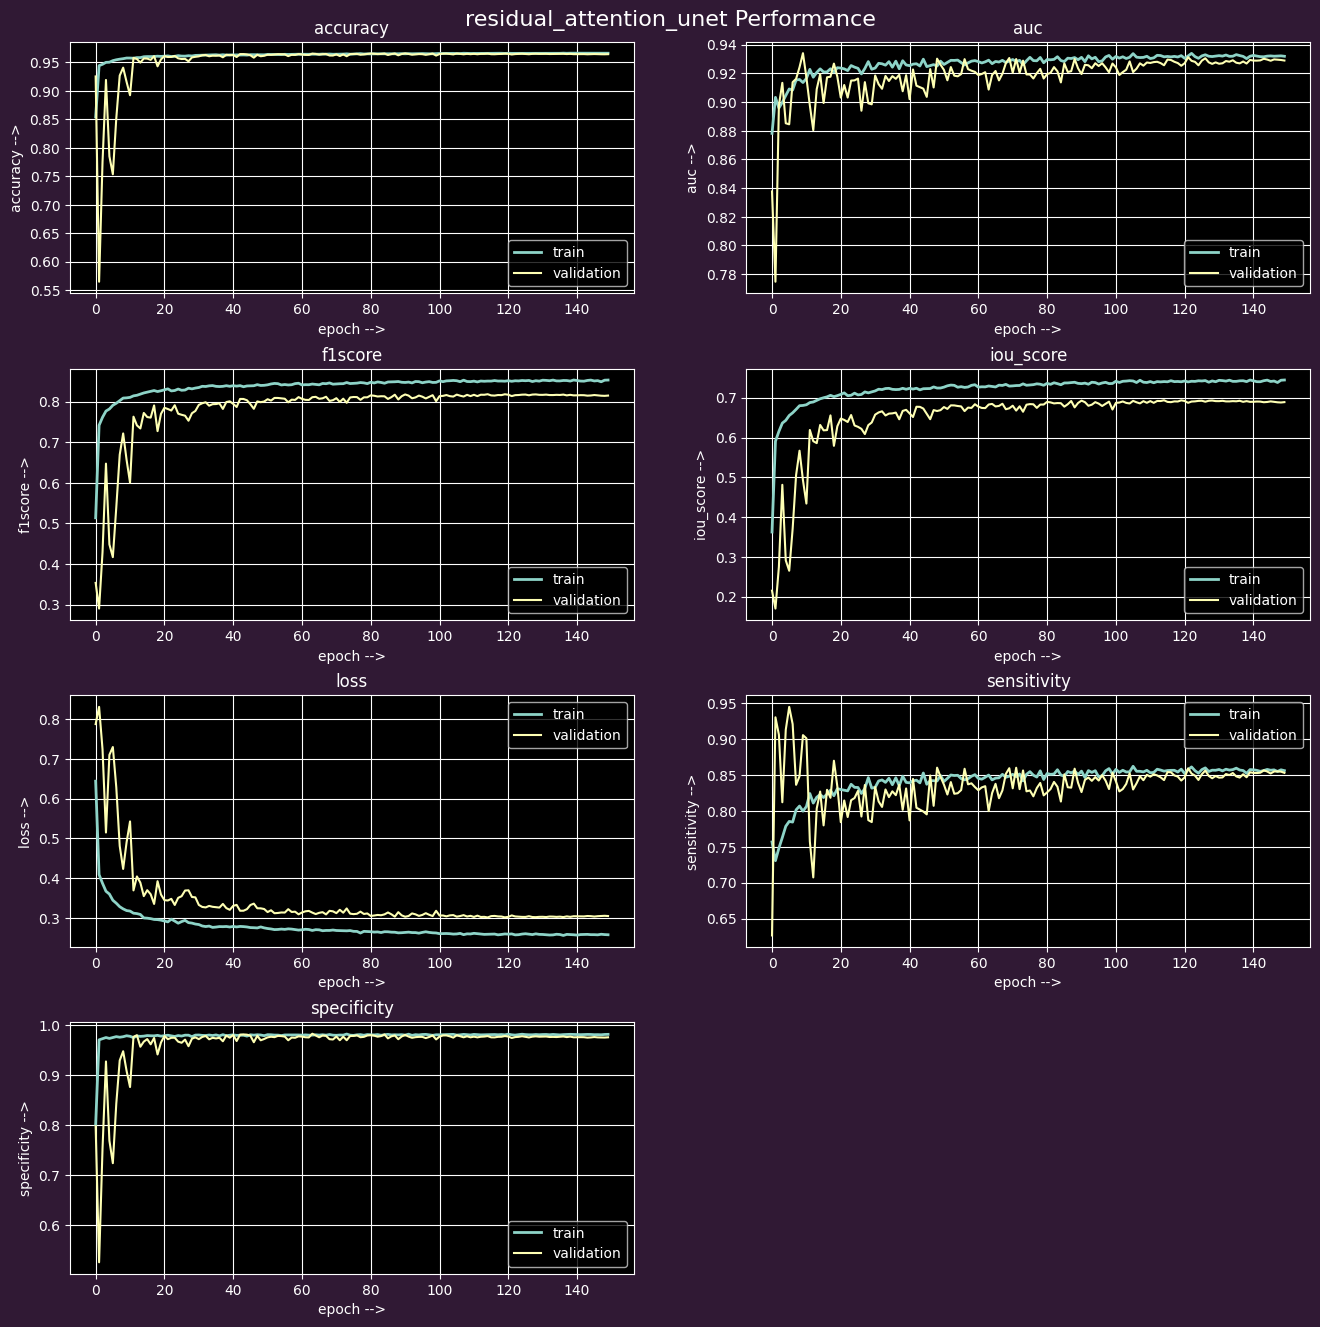

In [62]:
# model_name = "unet"
# History = History_dict[ model_name]

metric_List = list(History.keys())


plt.figure(figsize = (16,16),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=0.90)
for i,metric in enumerate(metric_List[:7],1):
    plt.subplot(4,2,i)
    plt.plot(History[metric],label='train',linewidth=2)
    plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
    plt.title(metric)
    plt.legend()
    plt.ylabel(metric + ' -->')
    plt.xlabel('epoch -->')
    plt.subplots_adjust(wspace=0.2, hspace=0.3) 
    plt.grid()
plt.show()

### > comparision plot

### > Sample Predictions

In [63]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [64]:
# def get_aug_image(image):
#     mask_pred_1 = get_pred_mask(image)
    
#     mask_pred_2 = get_pred_mask(np.fliplr(image))
#     mask_pred_2 = np.fliplr(mask_pred_2)
    
#     mask_pred_3 = get_pred_mask(np.flipud(image))
#     mask_pred_3 = np.flipud(mask_pred_3)
    
#     # mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
#     # mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
#     mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 )/3
#     return mask_pred_1 ,mask_pred_aug

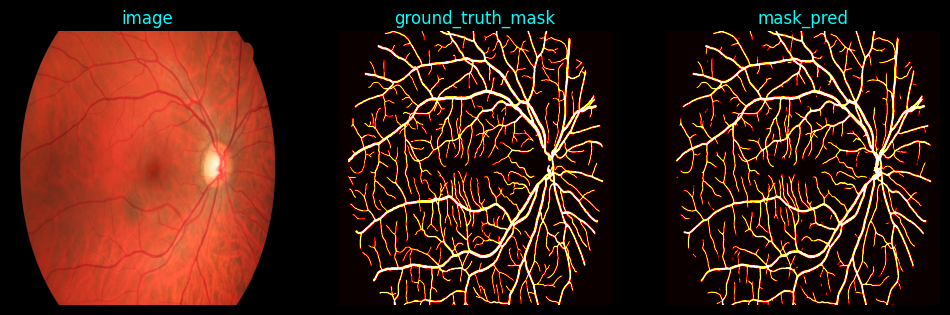

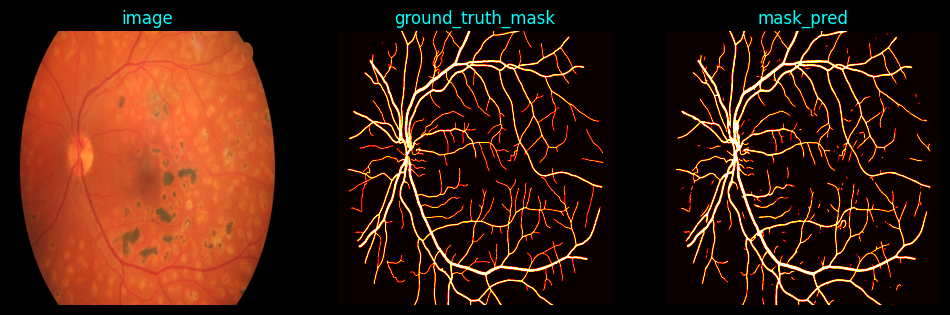

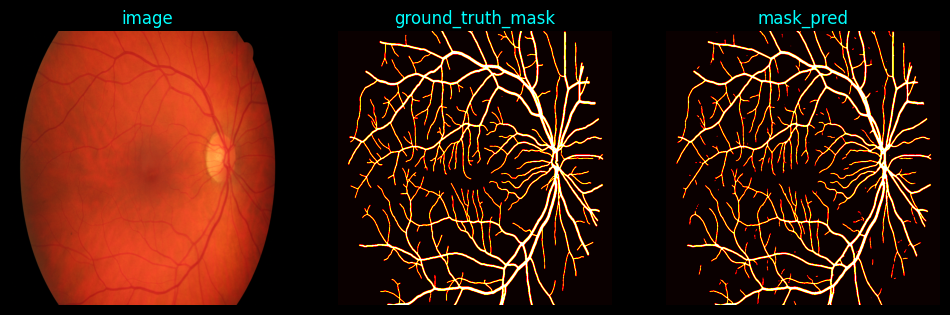

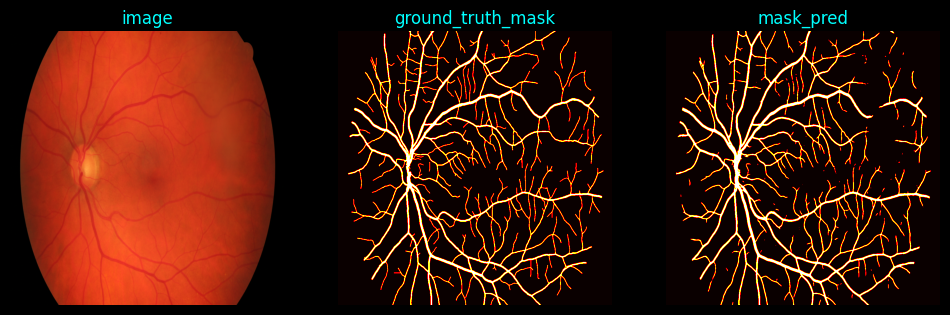

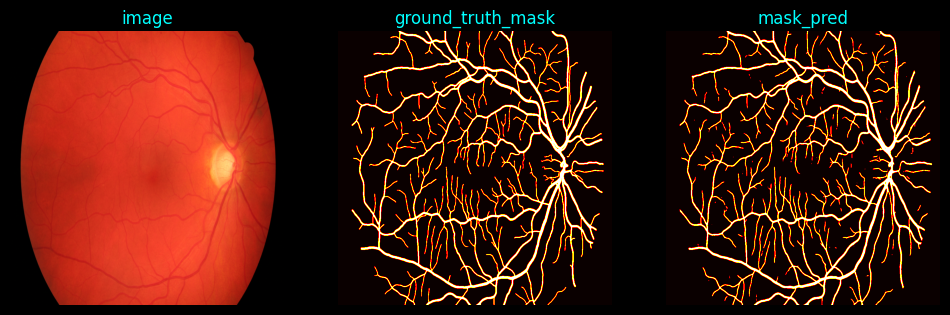

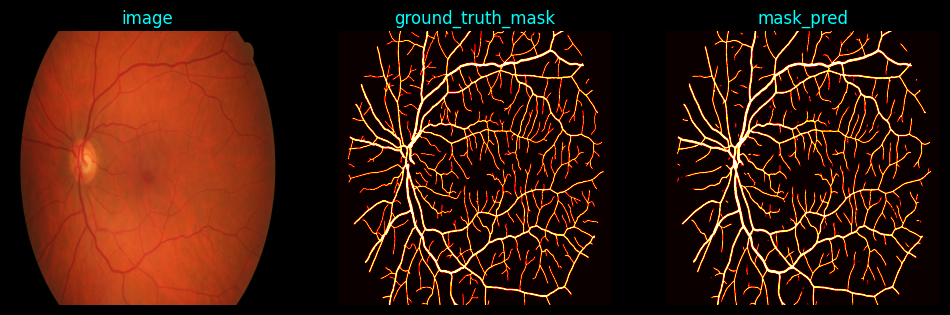

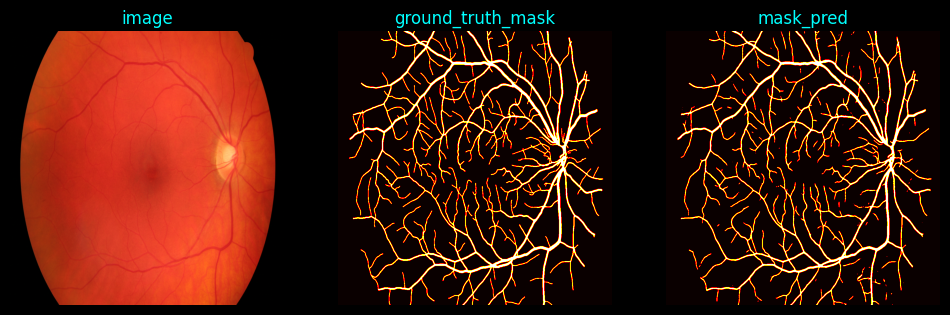

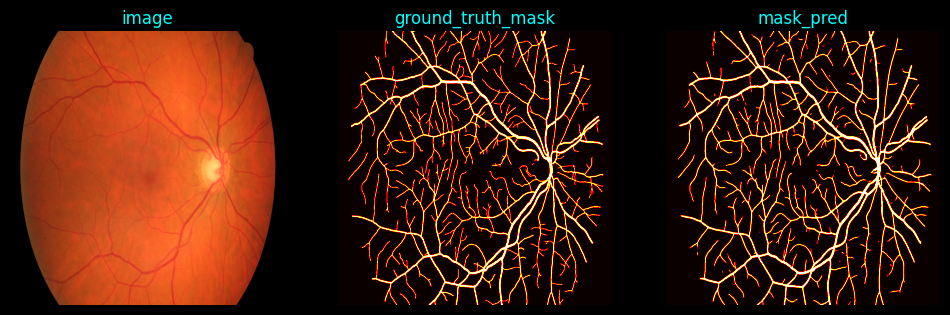

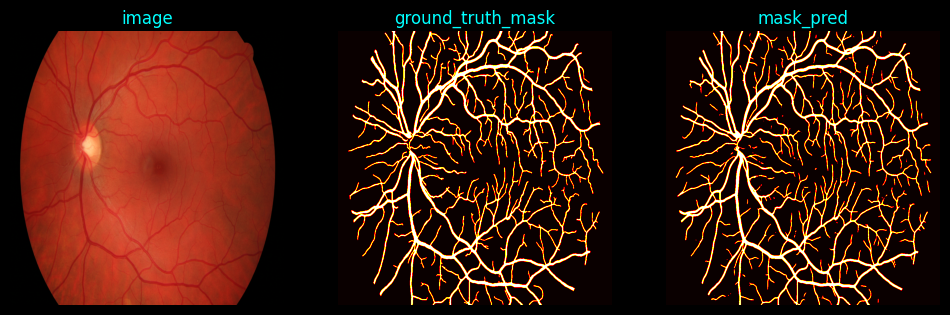

In [65]:
threshold = 0.5
for image , mask in zip(test_images , test_masks):
# for image , mask in zip(test_images , test_masks):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
#     mask_pred , mask_pred_aug = get_aug_image(image)
    mask_pred = get_pred_mask(image)
    
    mask_pred = (mask_pred>threshold)
#     mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image[...,:3] ,mask,mask_pred],['image','ground_truth_mask','mask_pred','mask_pred_aug'],size = 4,cmap='hot')

In [ ]:
# np.max(new_image)

In [ ]:
new_image = prev_Model(train_images[index:index+1])[0]
display_images([train_images[index][...,:3],new_image ,train_masks[index],],cmap = 'gray',size = 6,scaling='minmax',grid=(1,3))

In [ ]:
def image_gaus_edge(image,thresh1= 50 , kernel_size = 5,channel = None):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if(np.ndim(image)==3):
        if(channel):
            gray =  image[...,channel]
        else :
            gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # print(np.shape(image))
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    # Apply edge detection using Canny
    edge = cv2.Canny(blurred, threshold1=thresh1, threshold2=100)  # Adjust thresholds as needed

    return edge

In [ ]:
min_ = np.min(new_image ,axis = (0,1))
max_ = np.max(new_image ,axis = (0,1)) 

new_image = 255*(new_image - min_) /( max_ - min_)
new_image = np.array( new_image , dtype ='uint8')

In [ ]:
img_edge_1= image_gaus_edge(new_image, 300,3,channel=1)
img_edge_2= image_gaus_edge(new_image, 100,5,channel=0)
display_images([img_edge_1,img_edge_2,new_image,train_masks[index]] ,size=5,cmap = 'gray' , grid=(3,2))

## > Saving Results

In [ ]:
# [ 'pretrained_unet' ,'residual_unet' ,'r2_unet' , 'residual_attention_aunet']

In [67]:
import json

In [ ]:
with open(base_path+'dataset/account_content','r') as file:
    content = file.read()
Folder_key_dict  = json.loads(content)
# Address_dict

In [ ]:
# pip install mediafire

In [ ]:
from mediafire import MediaFireApi
from mediafire import MediaFireUploader
api = MediaFireApi()
uploader = MediaFireUploader(api)

In [68]:
def upload_models():
    base_path = 'Models' 
    try:
        os.mkdir(base_path)
    except:
        pass
        
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    for model_name , model in Model_dict.items():
        model_save_path = base_path + '/' + model_name + '.keras'
        model.save(model_save_path)

#         session = api.user_get_session_token(
#                         email='prajwalsharma.bt21cse@pec.edu.in',
#                         password='Praju@321',
#                         app_id='42511',
#         )
        
#         api.session = session
    
#         try:
#             print(model_name ,'upload started >>>')
#             with open(model_save_path ,'rb') as model_file:
#                 uploader = MediaFireUploader(api)
#                 %time result = uploader.upload(model_file , model_name , folder_key=folder_key)
#             print(model_name ,'uploaded successfully')
#             print('------------------------------------------------------------------------------------')
#         except Exception as e:
#             print("Error :",e)

In [69]:
def upload_Dict(Dict , dict_name = 'history_dict2'):
    base_path = 'Meta' 
    try:
        os.mkdir(base_path)
    except:
        pass
    
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    dict_file_name = base_path + '/' + dict_name+'.txt'
    
    dict_str = dict_str = json.dumps(Dict)
    dict_str = dict_str.encode()
    with open(dict_file_name,'wb') as dict_file :
        dict_file.write(dict_str)

#     session = api.user_get_session_token(
#                     email='prajwalsharma.bt21cse@pec.edu.in',
#                     password='Praju@321',
#                     app_id='42511',
#     )
#     api.session = session

#     try:
#         with open(dict_file_name ,'rb') as dict_file:
#             dict_str2 = dict_file.read()
#             Dict2 = json.loads(dict_str2)
            
#             uploader = MediaFireUploader(api)
#             %time result = uploader.upload(dict_file , dict_name , folder_key=folder_key) 
    
#     except Exception as e:
#         print("Error :",e)

In [70]:
upload_models()

In [71]:
upload_Dict(History_dict)

In [ ]:
# Model = models.load_model('Models/pretrained_unet_keras',compile=False)
# Model.evaluate(test_images,test_masks)

In [ ]:
# with open('Meta/history_dict_.txt' ,'rb') as dict_file:
#     dict_str2 = dict_file.read()
# Dict2 = json.loads(dict_str2)
# Dict2

In [ ]:
api = MediaFireApi()
# uploader = MediaFireUploader(api)

session = api.user_get_session_token(
                email='prajwalsharma.bt21cse@pec.edu.in',
                password='Praju@321',
                app_id='42511',
)